# House Price Prediction

## Exploratory Data Analysis

First importing the data, relevant packages and conducting EDA, in preparation for analysis.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import neighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
house_train = pd.read_csv("train.csv")
house_train.head()

Train_ID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0         1           60        RL          88.0     12128   Pave   NaN   
1         2          120        RL          48.0      6240   Pave   NaN   
2         3           50        RL         120.0     17360   Pave   NaN   
3         4           20        RL          73.0      8688   Pave   NaN   
4         5           80        RL          88.0     15312   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Pool Area Pool QC  Fence Misc Feature  \
0       IR1          Bnk    AllPub  ...         0     NaN  MnPrv          NaN   
1       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
2       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
3       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
4       Reg          Lvl    AllPub  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  SalePrice  
0        0      11    2006        WD          Abnorml     209000  
1        0      12    2009        WD           Normal     254000  
2        0       1    2010        WD           Normal     172500  
3        0       4    2006        WD           Normal     232000  
4        0       3    2009        COD          Normal     148000  

[5 rows x 81 columns]

In [21]:
house_test = pd.read_csv("test.csv")
house_test.head()

Test_ID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0        1           80        RL         120.0     19296   Pave   NaN   
1        2           20        RL          80.0     10928   Pave   NaN   
2        3          160        RL          24.0      2280   Pave   NaN   
3        4           20        RL          60.0      8428   Pave   NaN   
4        5           50        RM          50.0      9140   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Screen Porch Pool Area Pool QC  Fence  \
0       Reg          Lvl    AllPub  ...            0         0     NaN   GdWo   
1       Reg          Lvl    AllPub  ...            0         0     NaN    NaN   
2       Reg          Lvl    AllPub  ...            0         0     NaN    NaN   
3       IR2          Lvl    AllPub  ...            0         0     NaN    NaN   
4       Reg          HLS    AllPub  ...          200         0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Condition  
0          NaN        0       5     2009        WD           Normal  
1          NaN        0       8     2009        WD           Normal  
2          NaN        0       7     2009        WD           Normal  
3          NaN        0       7     2007        WD           Normal  
4          NaN        0       4     2010        COD          Normal  

[5 rows x 80 columns]

In [22]:
old_obs_n = house_train.shape[0]
print(f'Train dataset has {house_train.shape[0]} rows and {house_train.shape[1]} columns.')
print(f'Test dataset has {house_test.shape[0]} rows and {house_test.shape[1]} columns.')

Train dataset has 1570 rows and 81 columns.
Test dataset has 1210 rows and 80 columns.


The datasets are moderately large and have a large number of features.

In [23]:
print(f'There are {house_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 24 columns in train dataset with missing values.


There are a number of columns with missing values. These need to be investigated before we engage in feature engineering.

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(house_train.dtypes)

Train_ID             int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

There are a number of qualitative variables that may require dummy variables to be created for these. This will be applied after an individual inspection of each of the variables in feature engineering.

Before identifying the most ideal features through a correlation heatmap feature engineering, we will first delve into each of the variables to ensure that the data having been inputted is logically consistent i.e. values correspond logically with the variable.

In [25]:
house_train['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

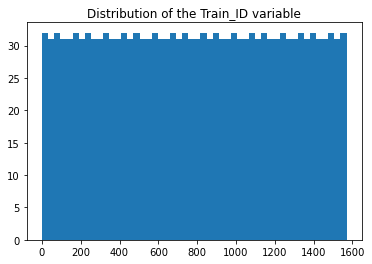

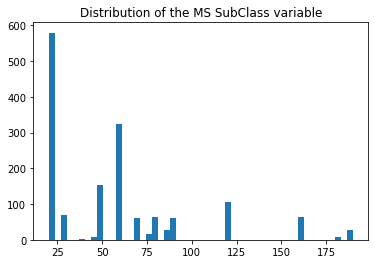

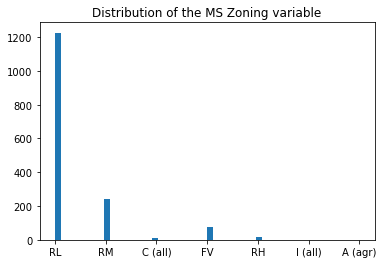

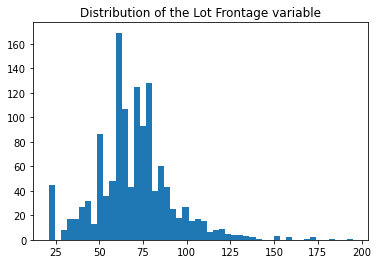

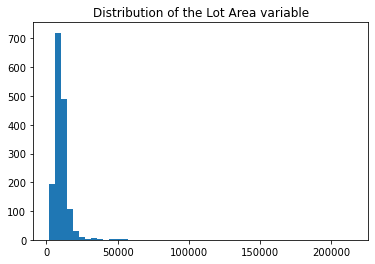

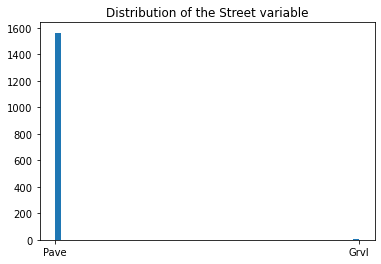

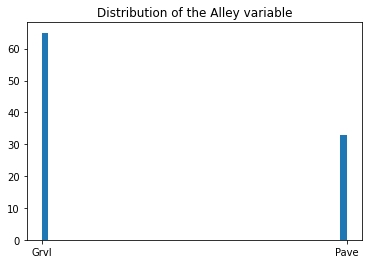

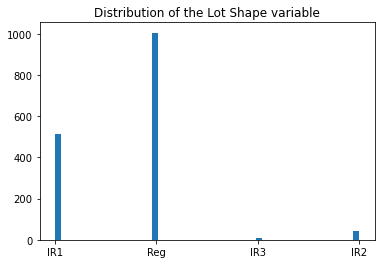

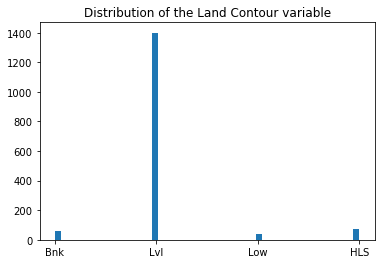

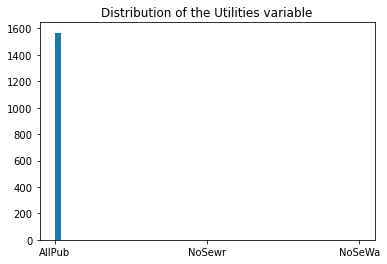

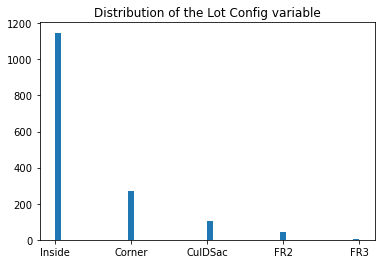

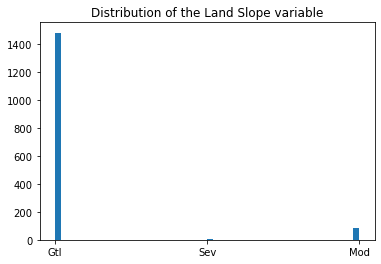

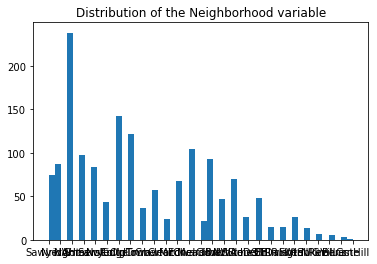

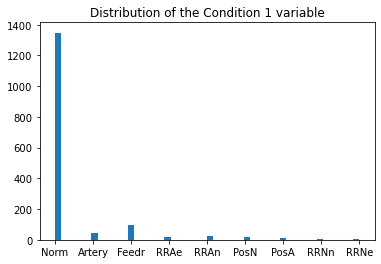

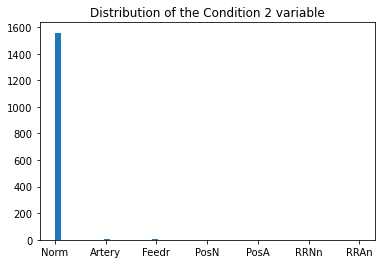

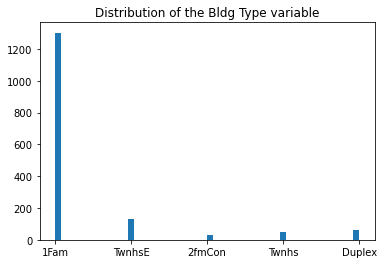

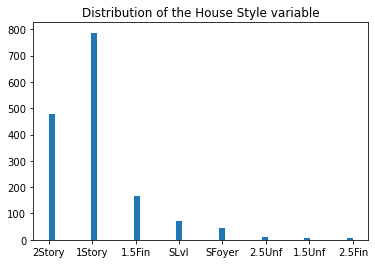

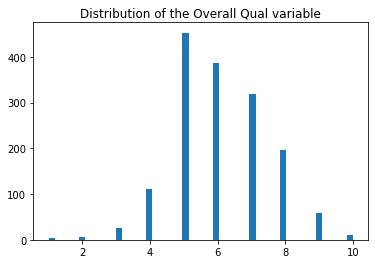

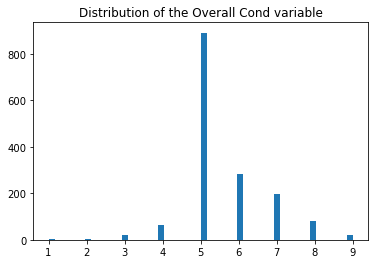

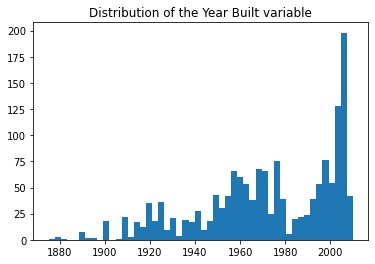

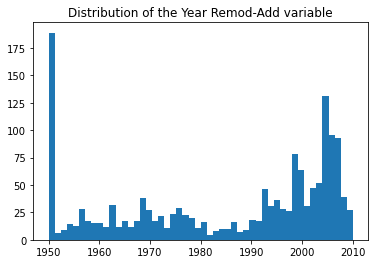

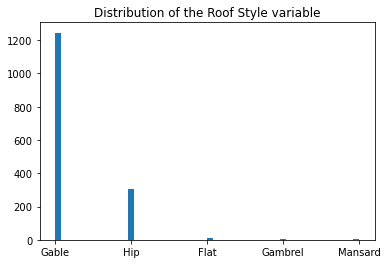

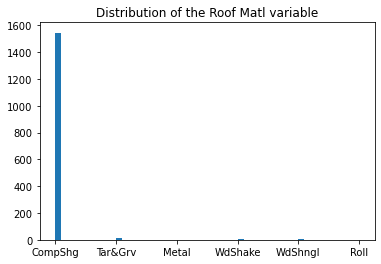

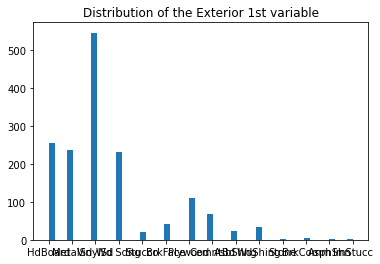

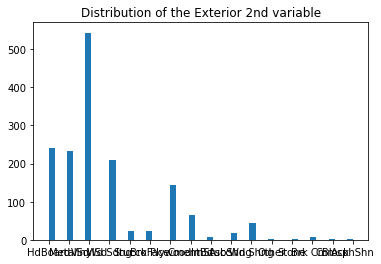

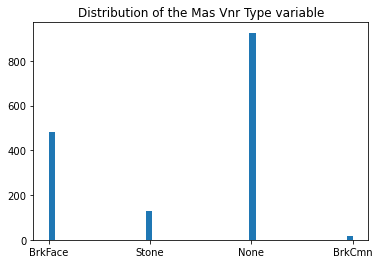

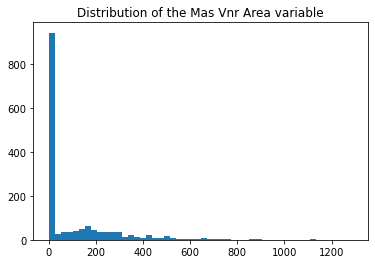

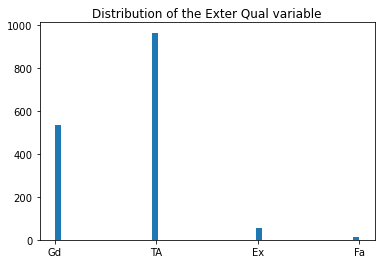

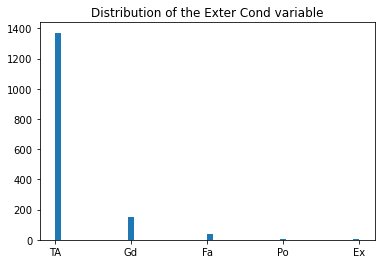

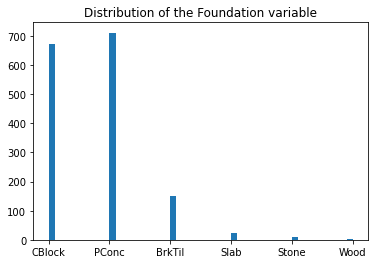

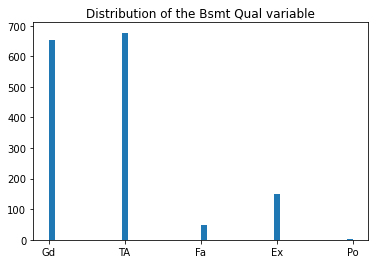

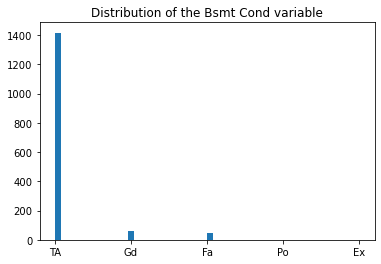

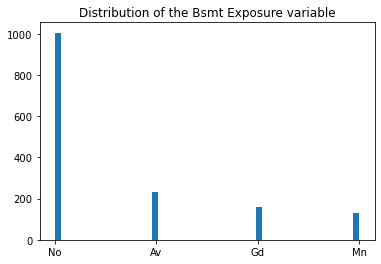

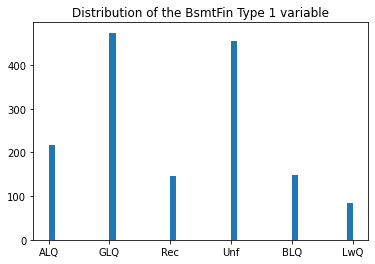

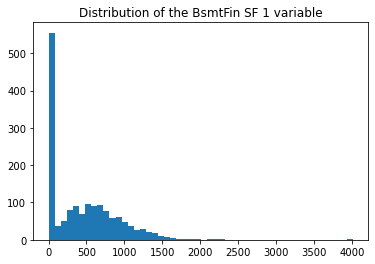

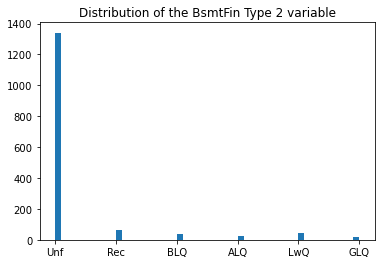

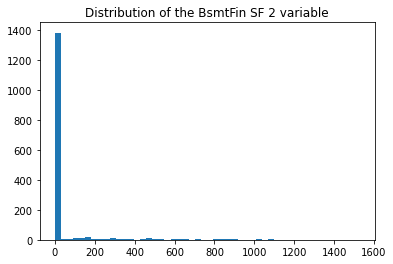

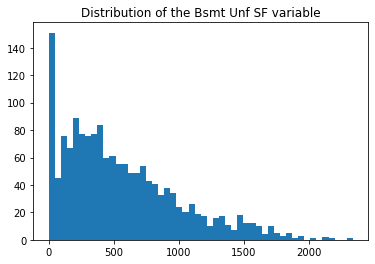

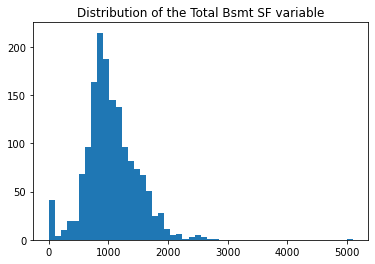

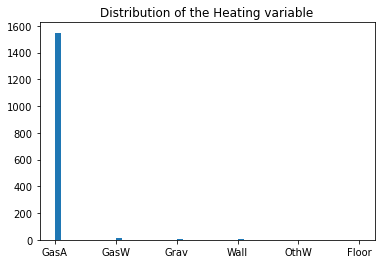

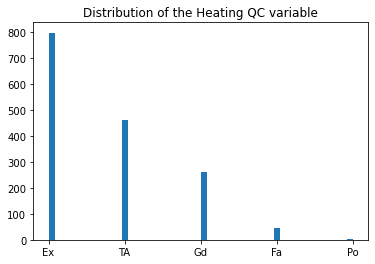

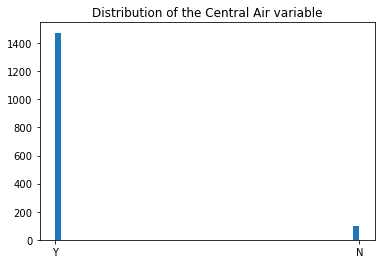

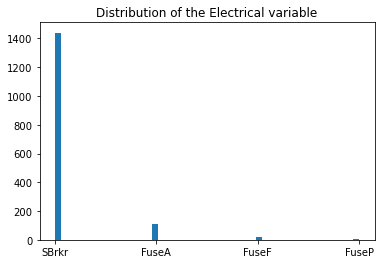

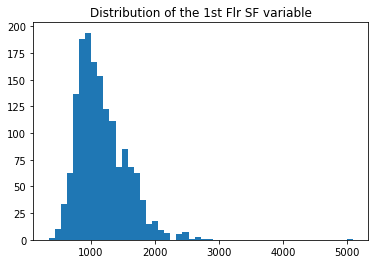

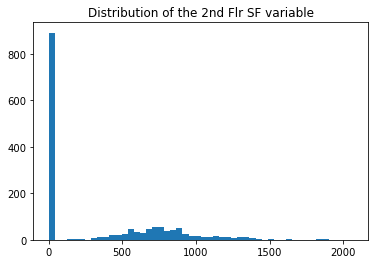

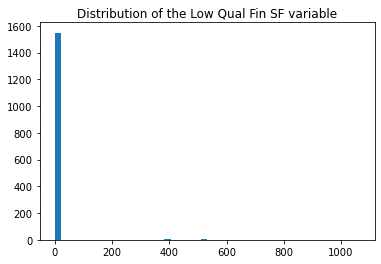

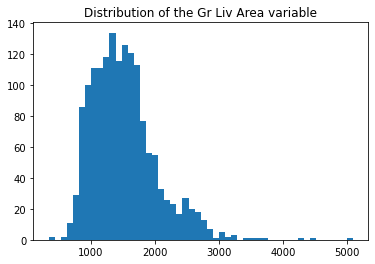

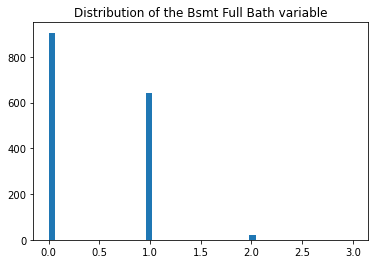

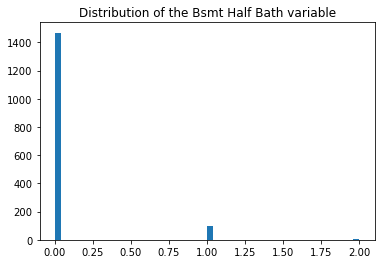

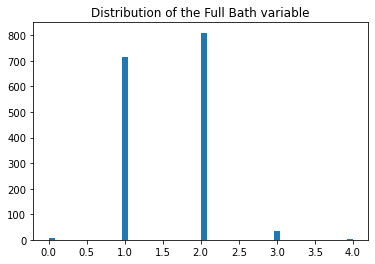

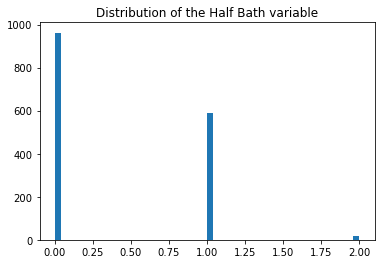

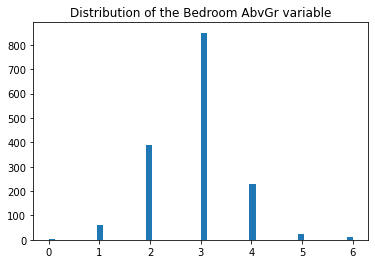

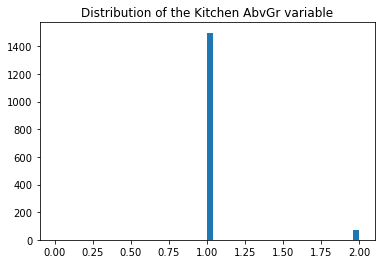

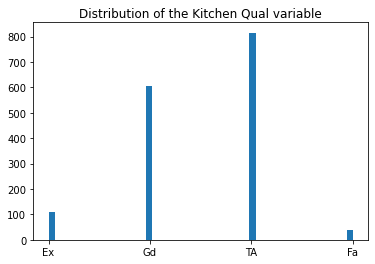

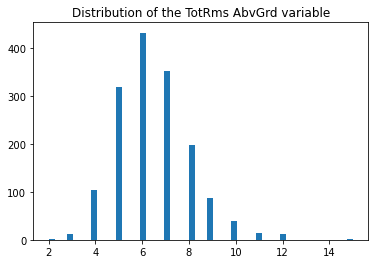

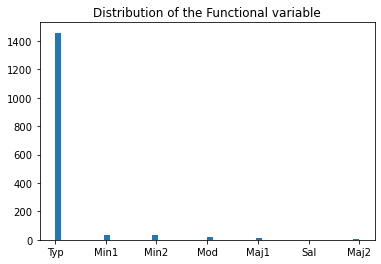

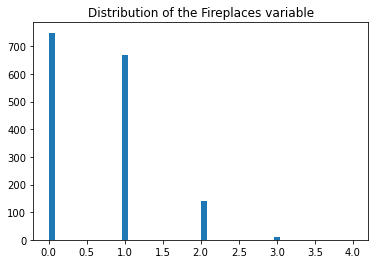

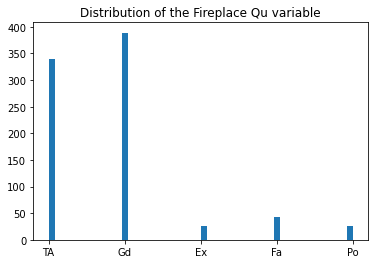

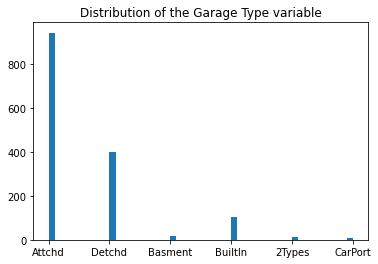

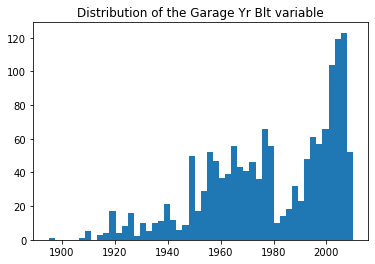

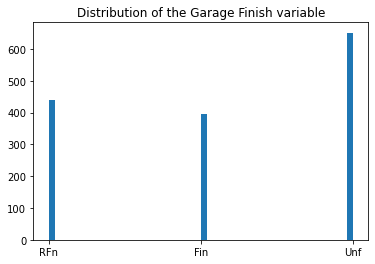

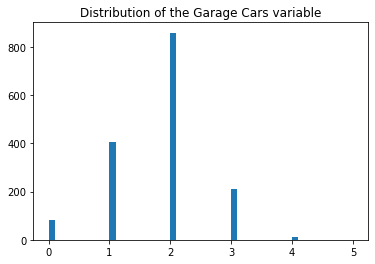

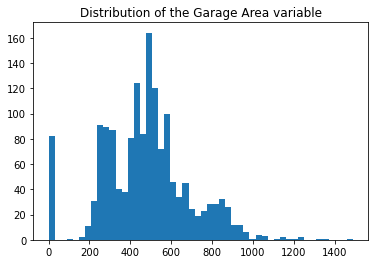

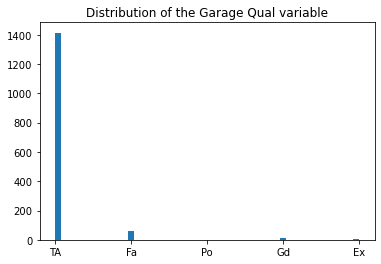

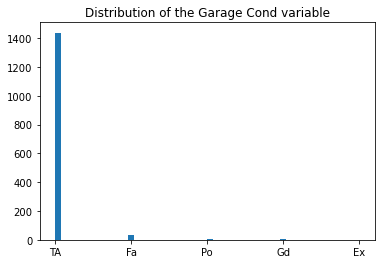

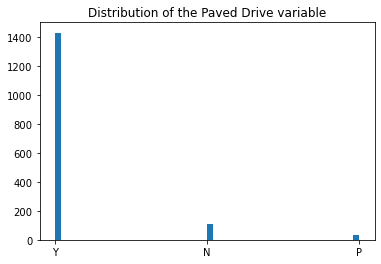

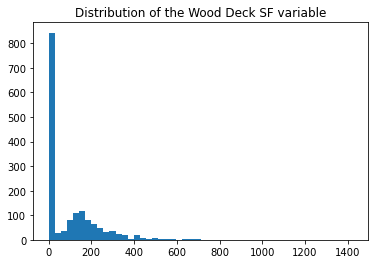

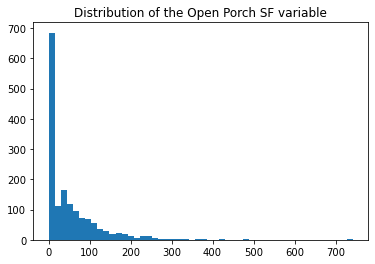

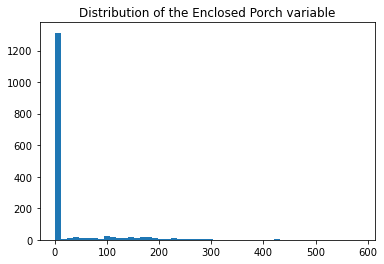

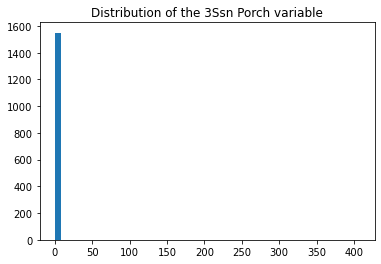

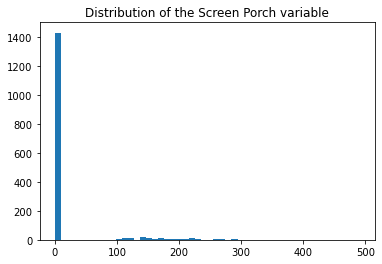

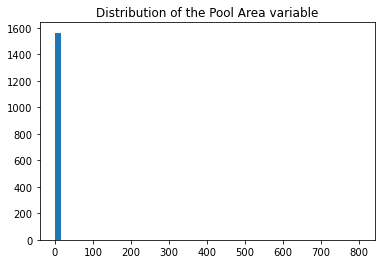

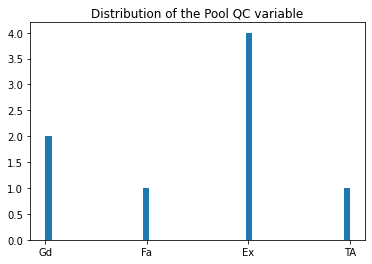

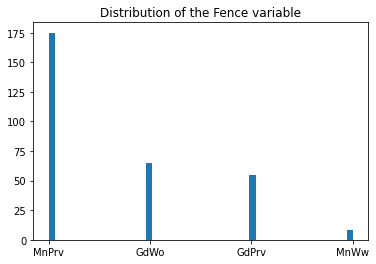

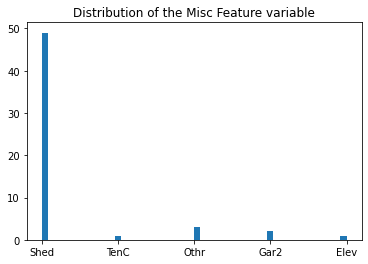

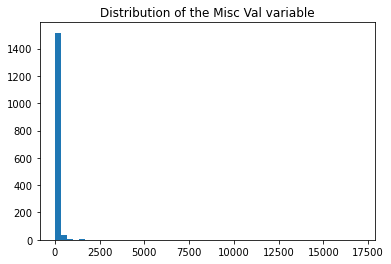

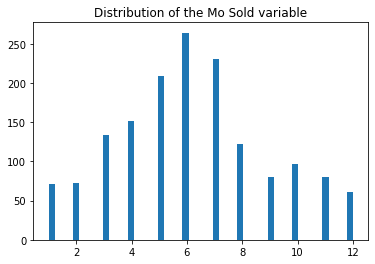

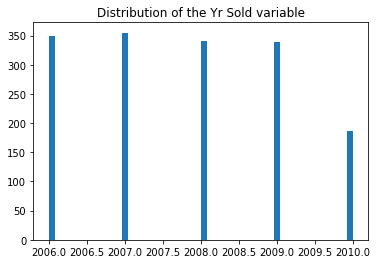

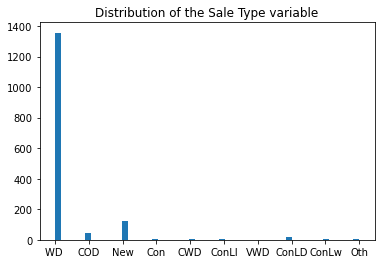

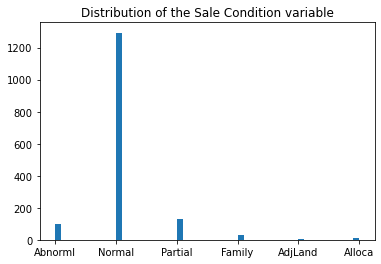

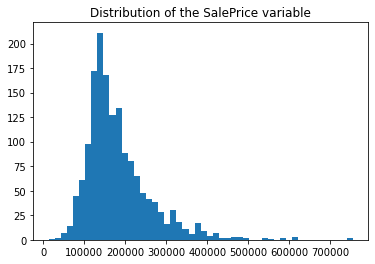

In [26]:
col_names = list(house_train.columns)

# for i in col_names:
#     plt.hist(house_train[i].dropna(), bins=50);
#     if i == "Year Remod/Add":
#         i = "Year Remod-Add"
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     else:
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     plt.show()

Nothing too unusual is noticeable in the data, however there is some skewness to a number of features and should be considered in feature engineering.

Now, using an IQR approach to identifying outliers these should be noted.

In [27]:
# to only consider numerical features in outlier detection
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = house_train.select_dtypes(include=numerics).copy()

In [29]:
del newdf['Train_ID']

In [30]:
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

In [31]:
house_train_out = newdf[((newdf < (Q1 - 1.5 * IQR)) |(newdf > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [32]:
print(f'The dataset has {house_train_out.shape[0]} outliers.')

The dataset has 966 outliers.


## Feature Engineering

First we will examine for the most relevant numerical variables in the dataset. Later, the categorical features will be converted to dummies so that they can be usable for predictive modelling.

Minusing the year it was sold in to the year it was constructed the new variable 'Age' was created. Also, minusing the last year it was remodelled or had additions made to the house to the year it was sold was added as the 'Last remod/add' feature. 

In [37]:
house_train['Age'] = house_train['Yr Sold'] - house_train['Year Built']
house_train['Last remod/add'] = house_train['Yr Sold'] - house_train['Year Remod/Add']

In [38]:
num_house_train = house_train[['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']].copy()

Let's create a series of scatter plots of the narrowed numerical features against 'SalePrice' to understand what relationships may be present between these variables.

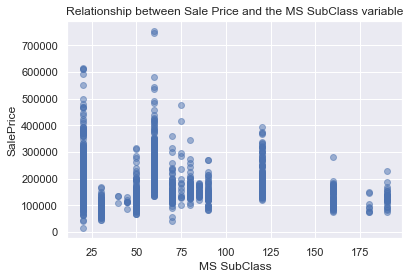

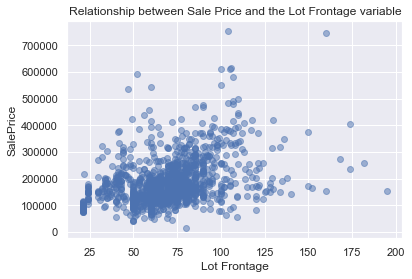

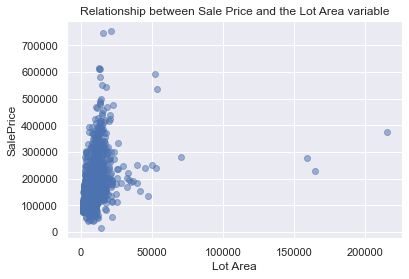

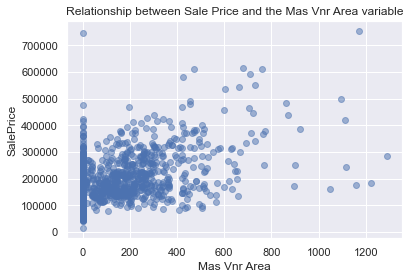

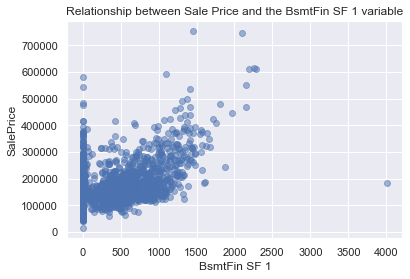

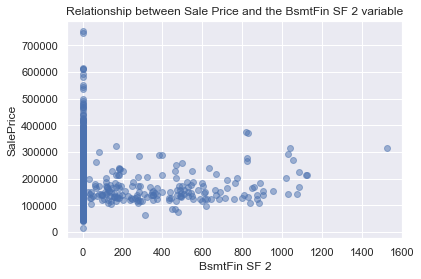

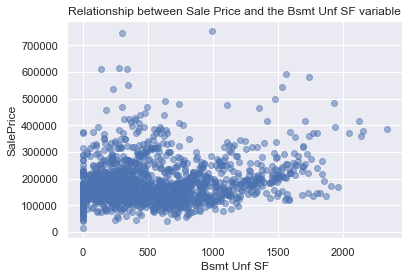

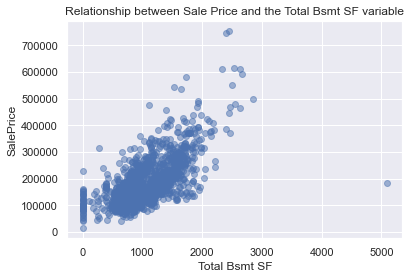

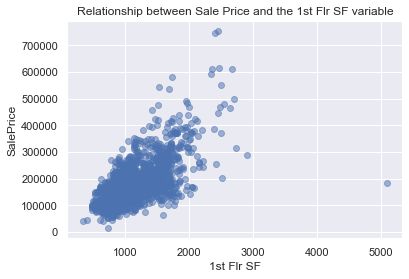

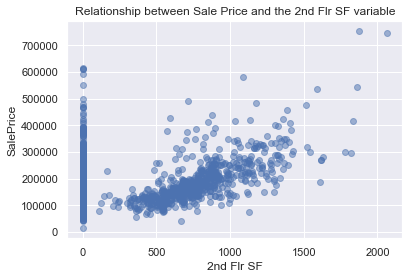

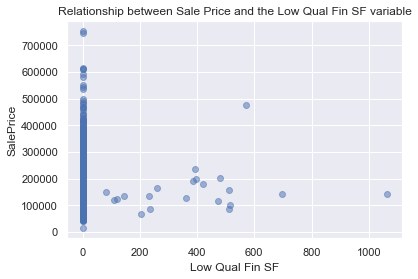

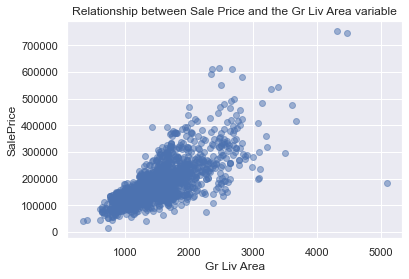

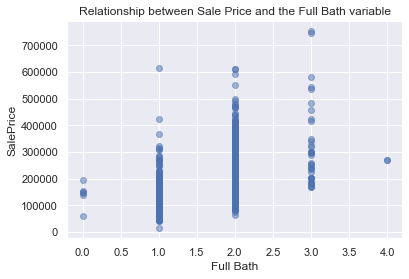

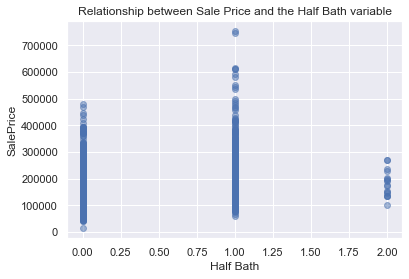

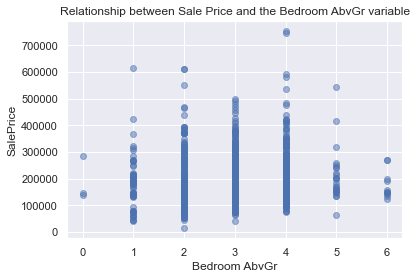

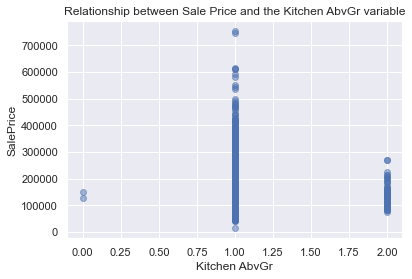

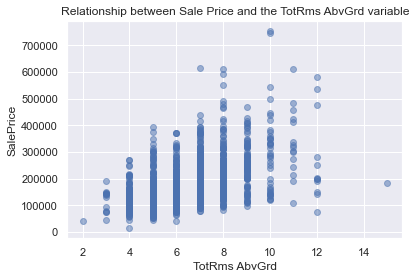

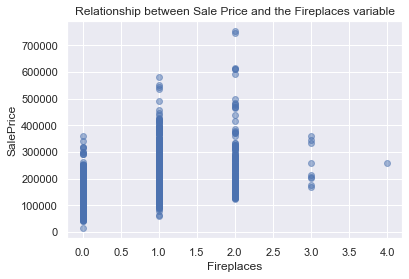

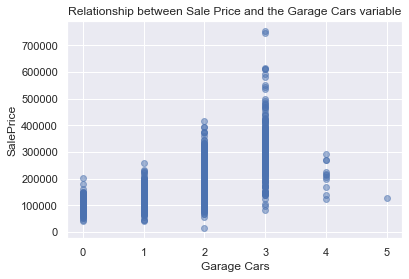

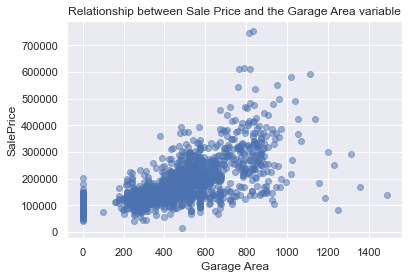

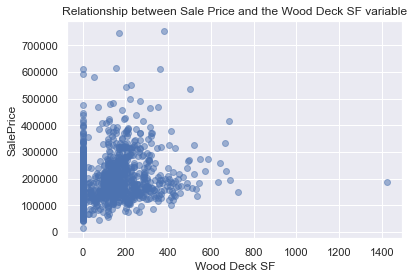

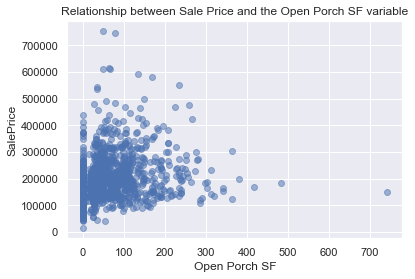

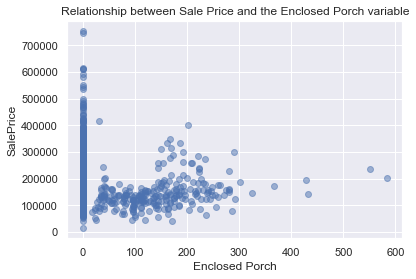

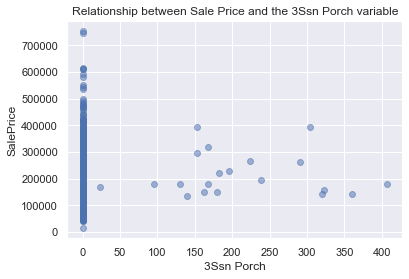

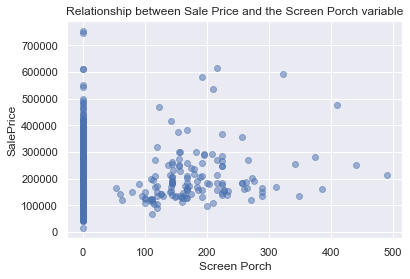

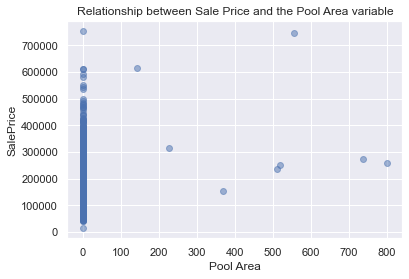

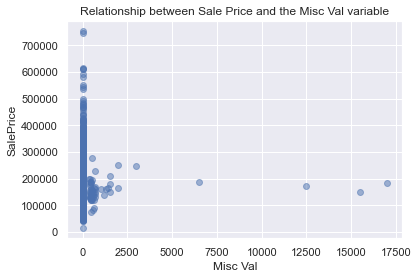

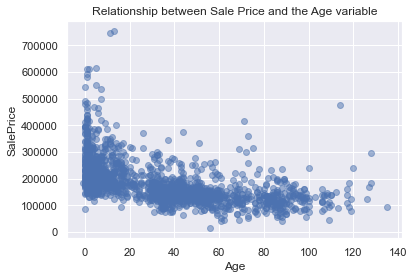

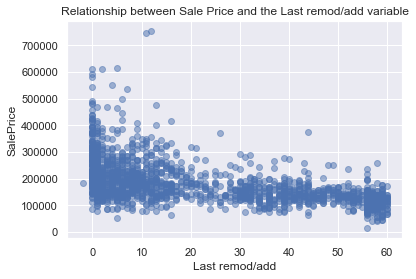

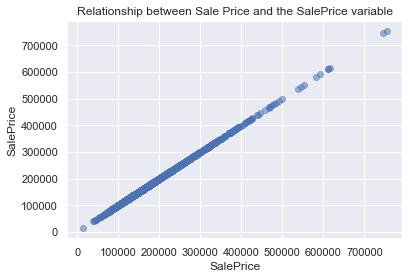

In [41]:
col_names = list(num_house_train.columns)

# for i in col_names:
#     plt.scatter(num_house_train[i], num_house_train['SalePrice'], alpha = 0.5);
#     plt.title(f'Relationship between Sale Price and the {i} variable');
#     sns.set(font_scale=1)
#     plt.xlabel(i)
#     plt.ylabel("SalePrice")
#     if i == "Last remod/add":
#         plt.savefig(f'Relationship between Sale Price and the Last remod-add variable')
#     else:
#         plt.savefig(f'Relationship between Sale Price and the {i} variable')
#     plt.show()

Since it was clear earlier that there was some heavy skewing of the data in some features, this has made the identifying of a relationship amongst these features more difficult. Therefore, for the purposes of making use of as many variables as possible the identified outliers from above will be removed and the scatter plots re-examined.

In [42]:
Q1 = num_house_train.quantile(0.25)
Q3 = num_house_train.quantile(0.75)
IQR = Q3 - Q1

In [43]:
num_house_train_out = num_house_train[~((num_house_train < (Q1 - 1.5 * IQR)) |(num_house_train > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [45]:
print(f'The dataset has {num_house_train_out.shape[0]} observations left.')

The dataset has 667 observations left.


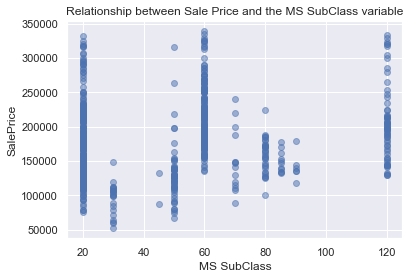

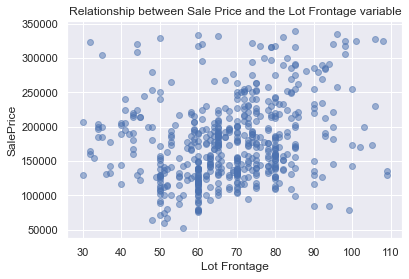

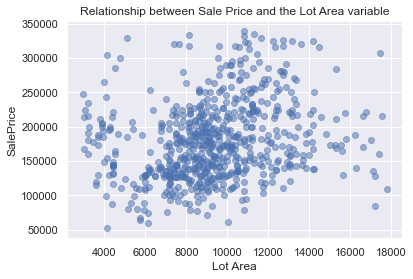

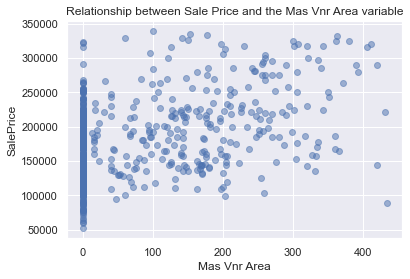

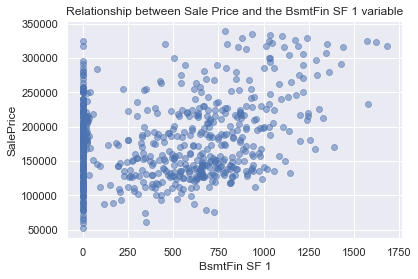

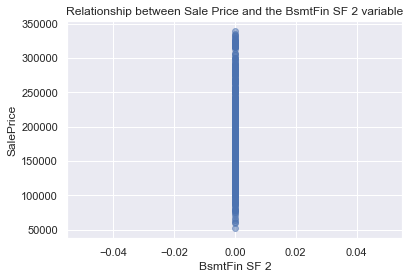

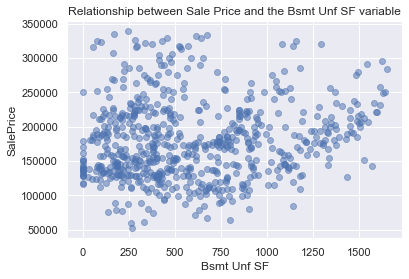

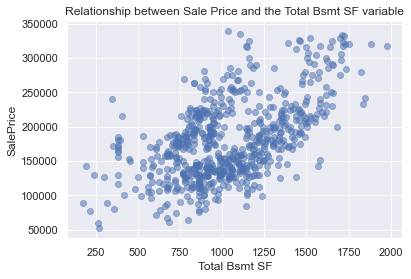

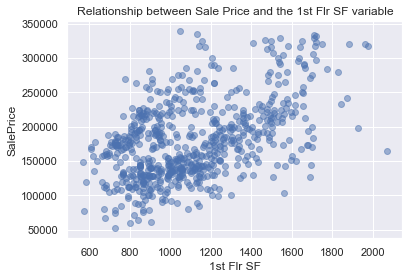

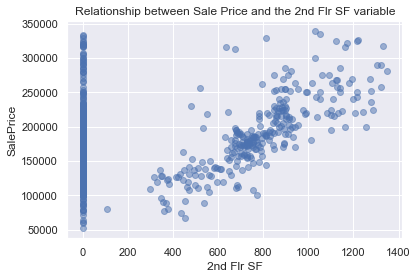

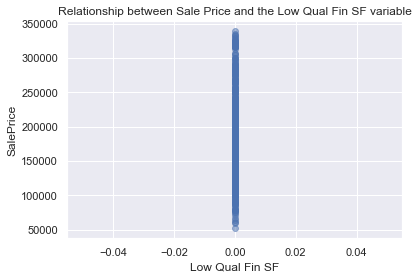

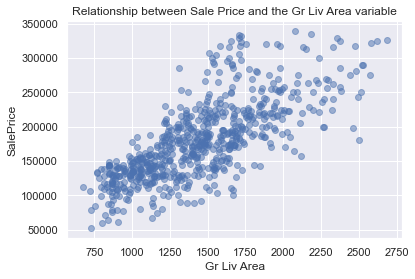

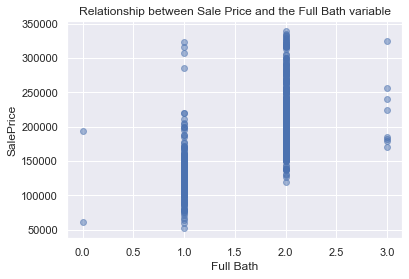

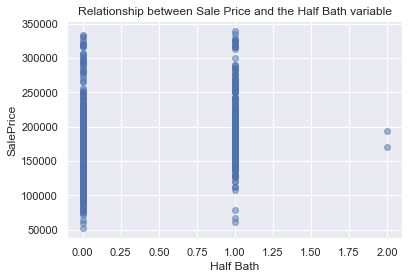

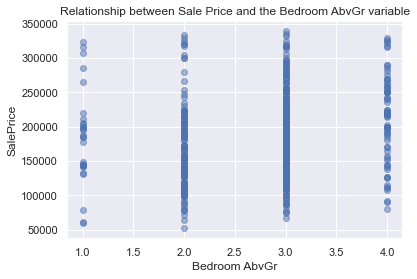

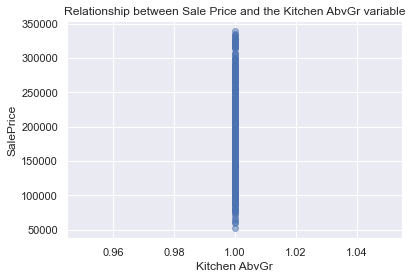

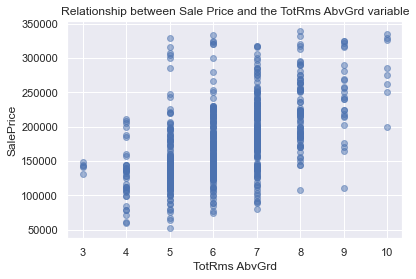

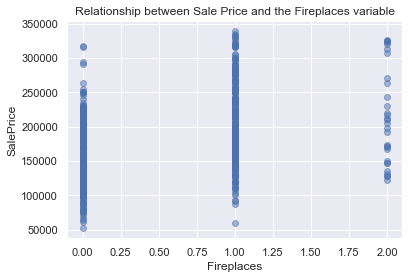

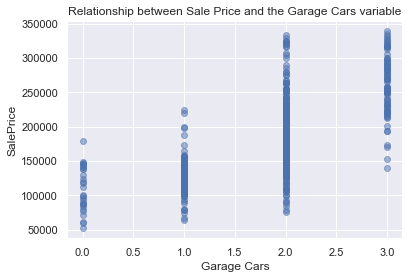

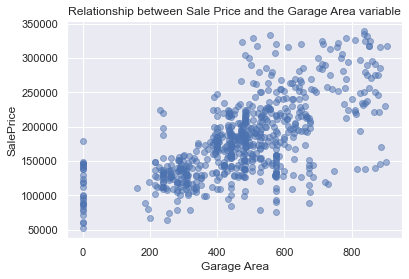

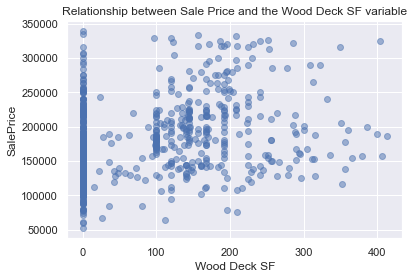

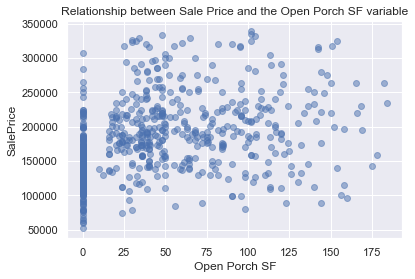

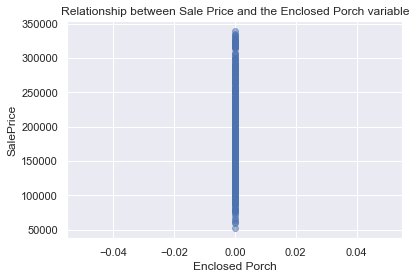

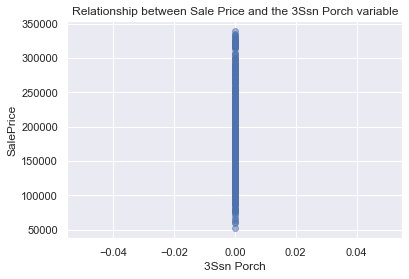

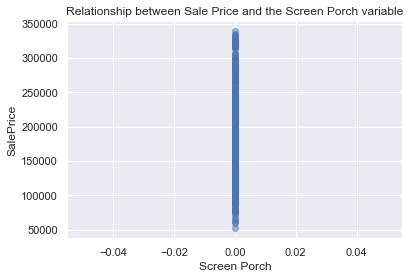

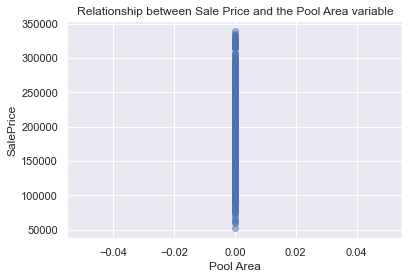

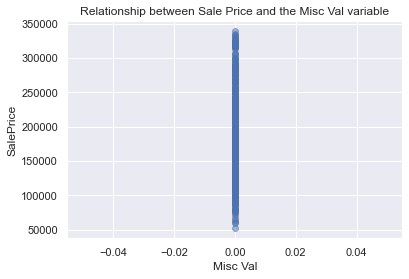

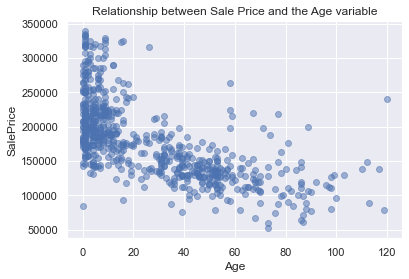

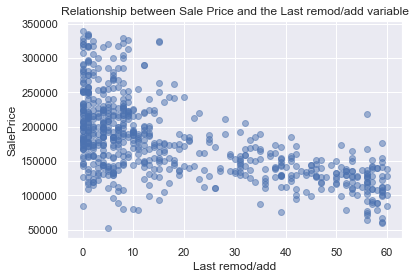

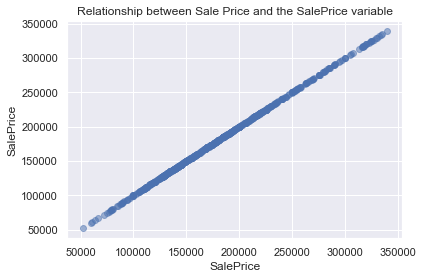

In [46]:
for i in col_names:
    plt.scatter(num_house_train_out[i], num_house_train_out['SalePrice'], alpha = 0.5);
    plt.title(f'Relationship between Sale Price and the {i} variable');
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    if i == "Last remod/add":
        plt.savefig(f'Relationship between Sale Price and the Last remod-add variable')
    else:
        plt.savefig(f'Relationship between Sale Price and the {i} variable')
    plt.show()

In [59]:
nan_values = num_house_train_out.isna()
nan_columns = nan_values.any()

columns_with_nan = num_house_train_out.columns[nan_columns].tolist()
columns_with_nan

['Lot Frontage',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF']

The scatter plots above show that variables...(tell which features look the most promising)

To see if any relationship is present between the categorical variables and the Sales Price predictor, box plots will be made between these.

In [74]:
num_var = ['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']

col_names = list(house_train.columns)

def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

cat_var = returnNotMatches(col_names, num_var)[0]
cat_var.remove('Train_ID')
cat_var.remove('Year Built')
cat_var.remove('Year Remod/Add')

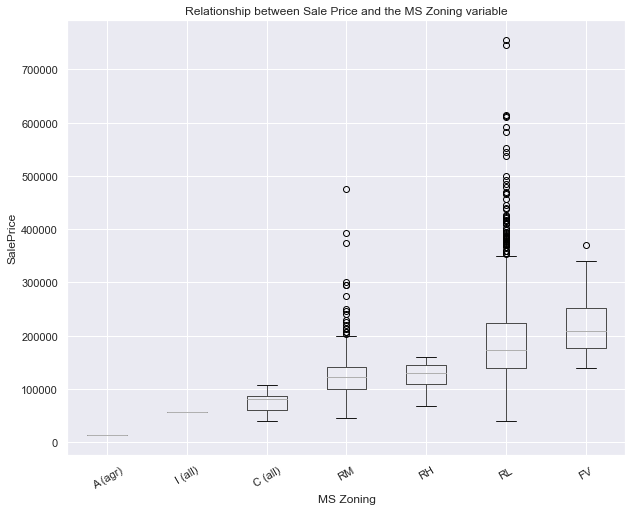

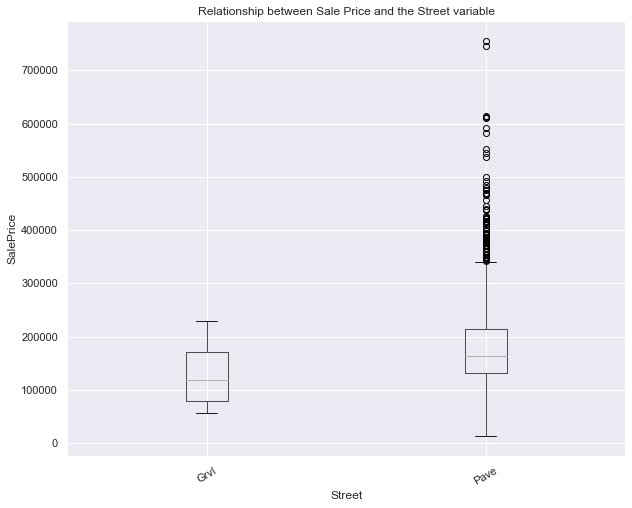

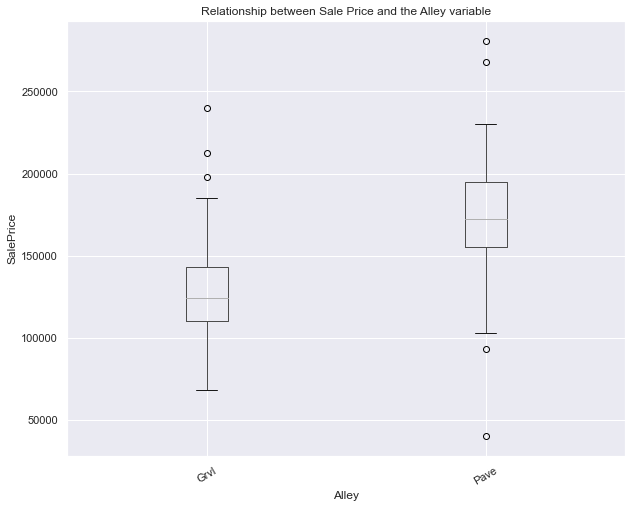

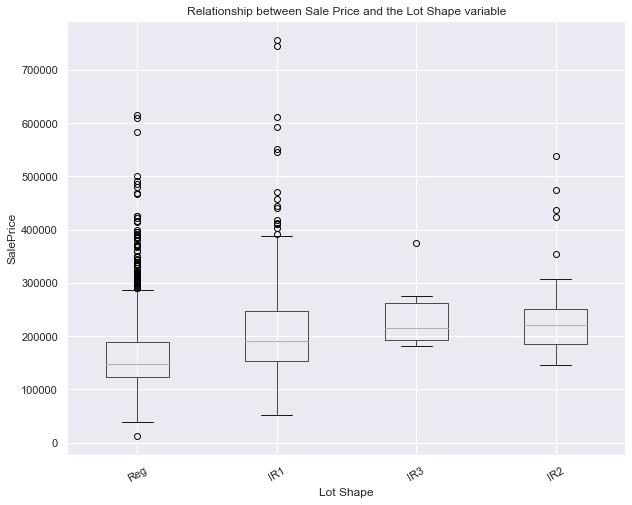

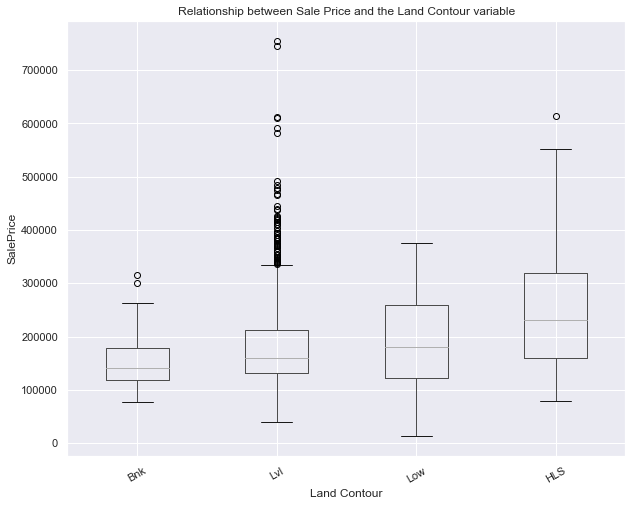

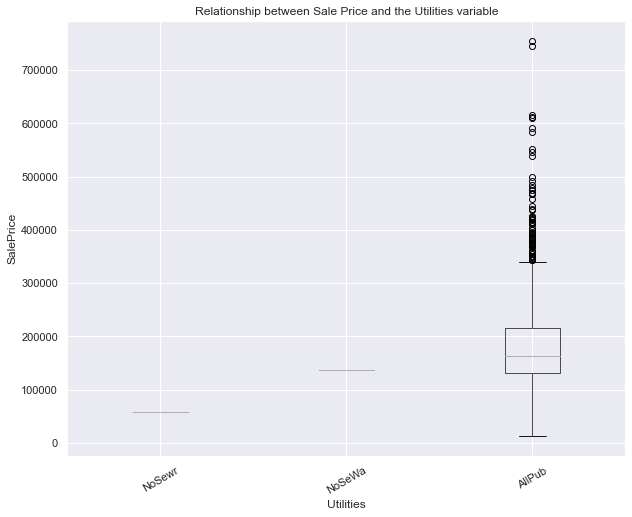

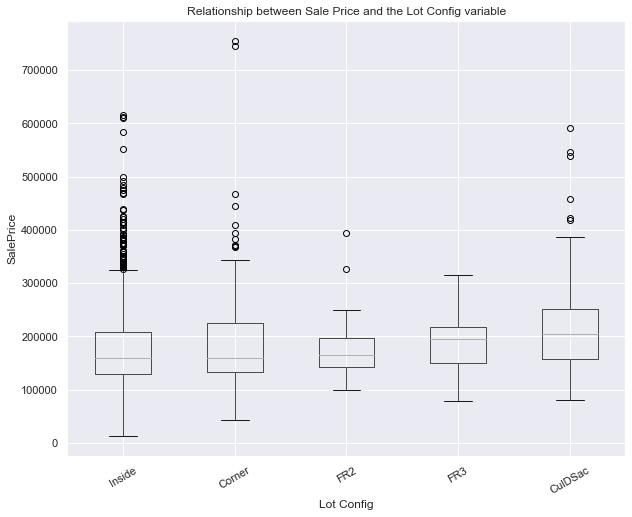

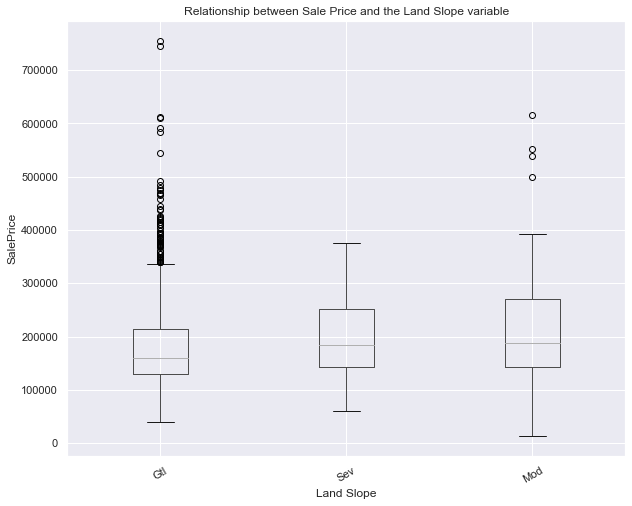

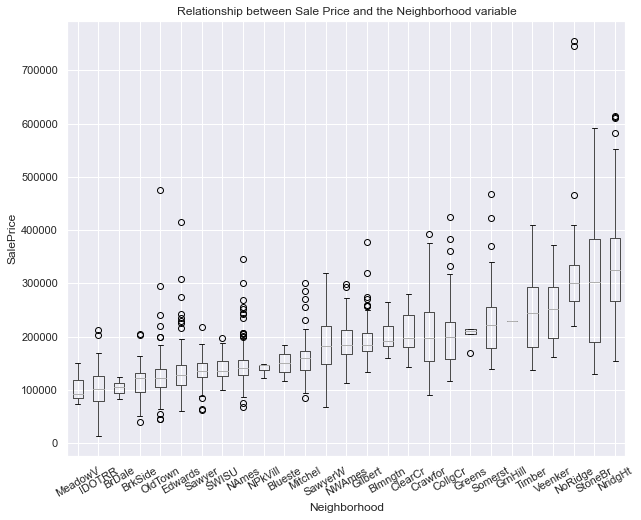

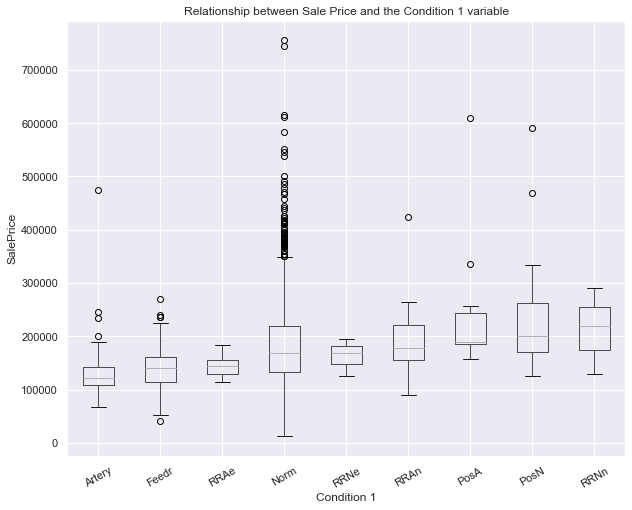

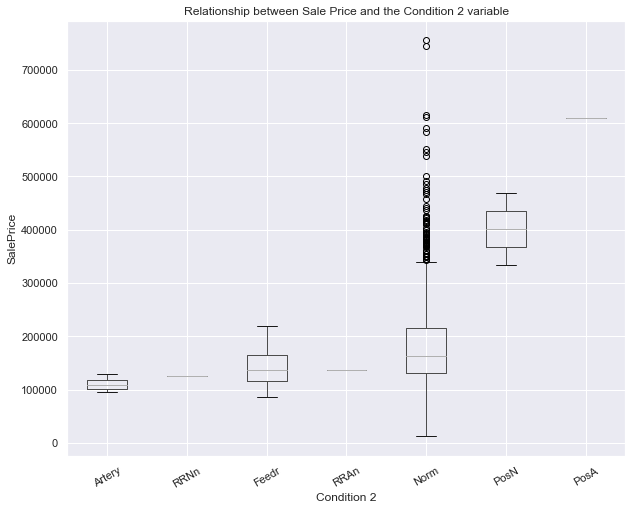

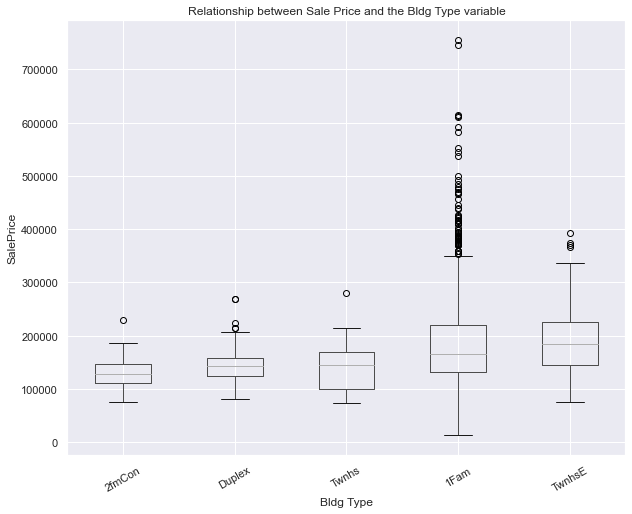

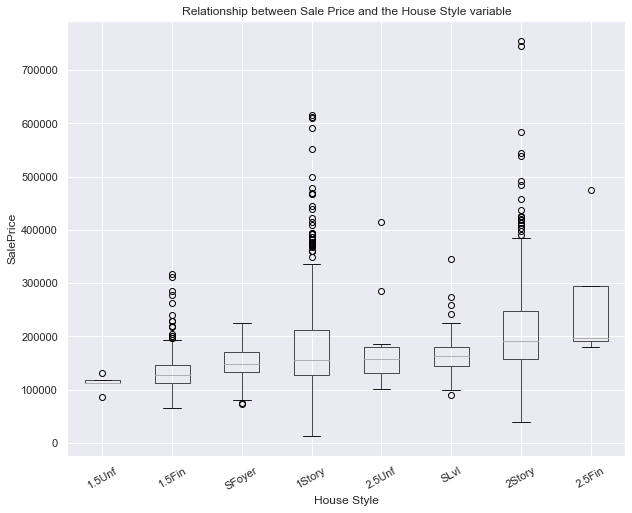

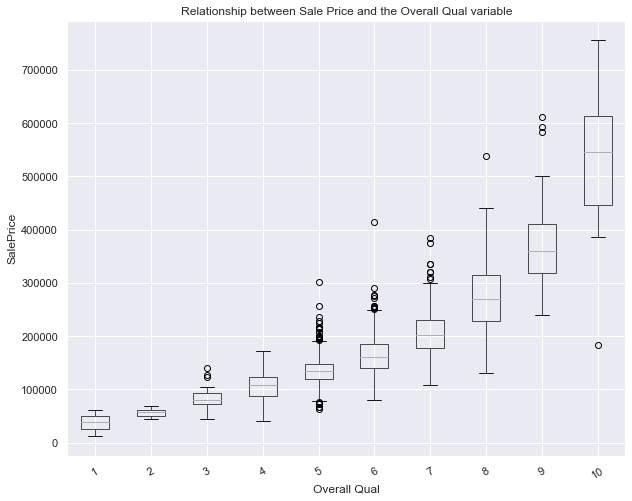

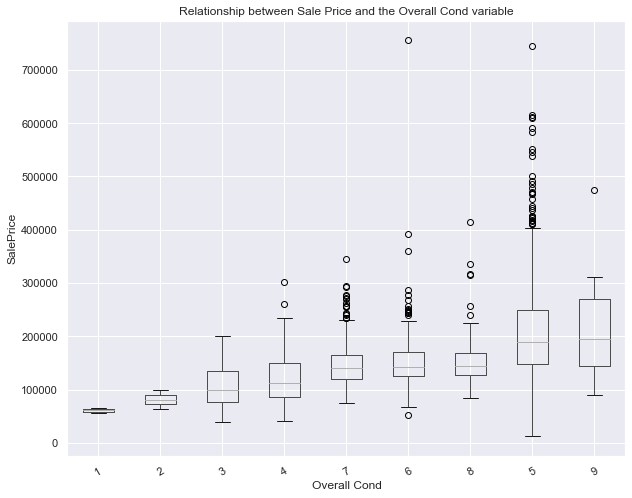

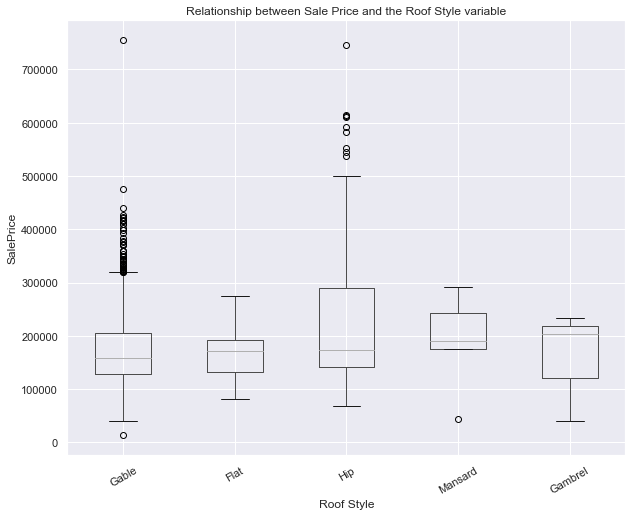

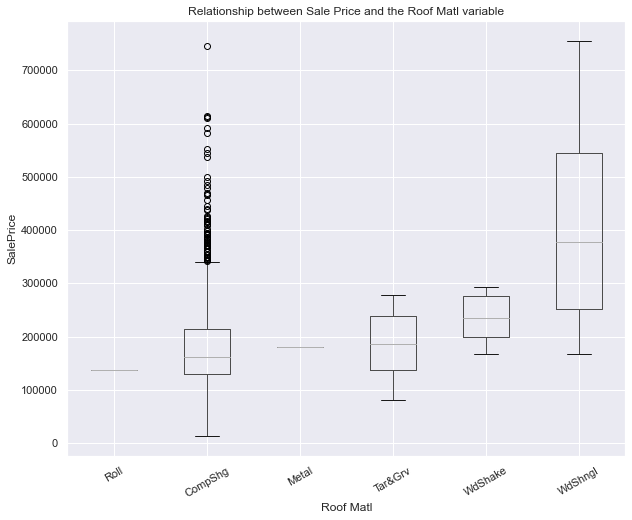

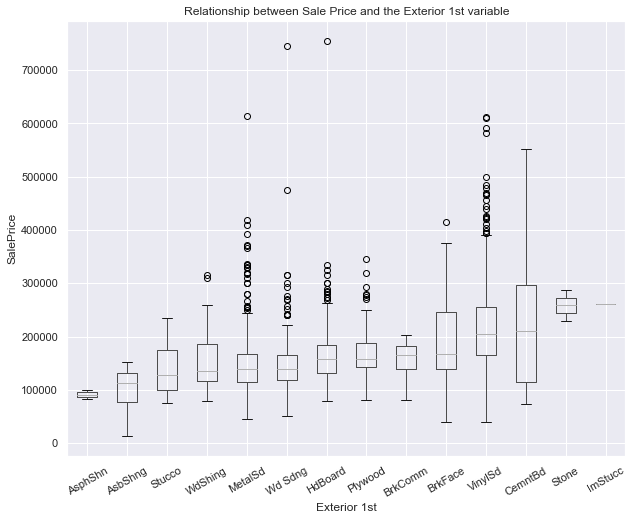

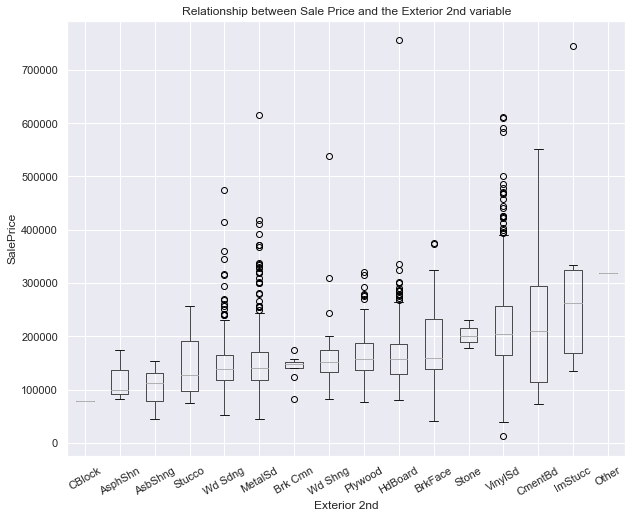

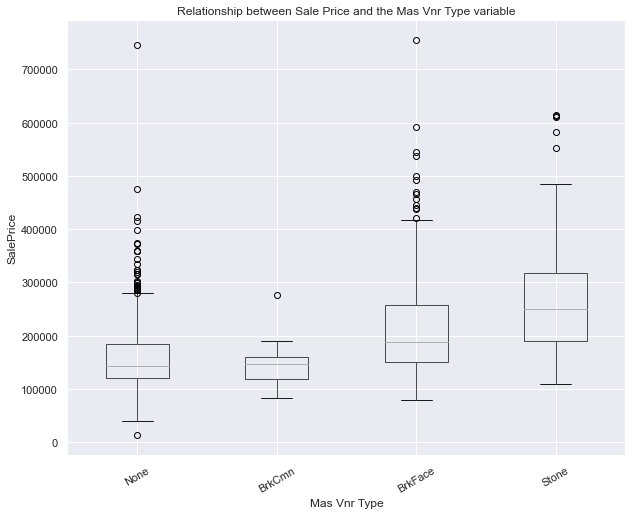

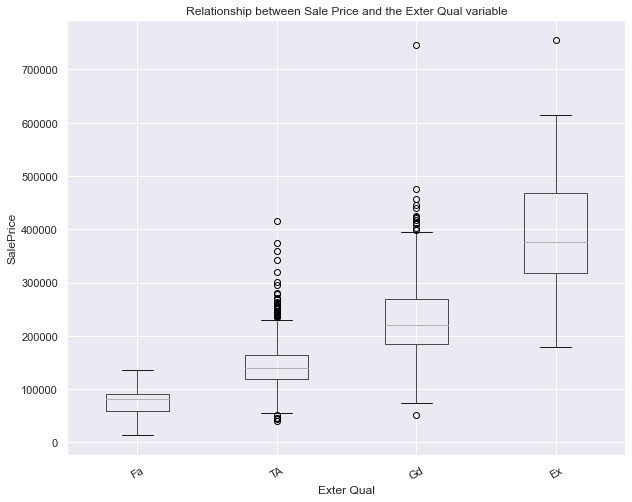

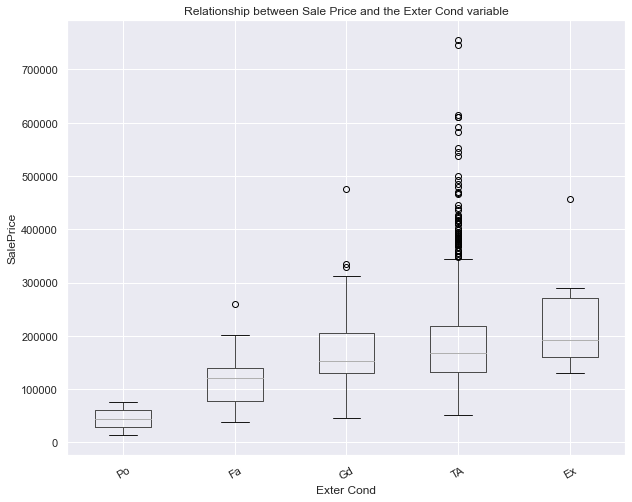

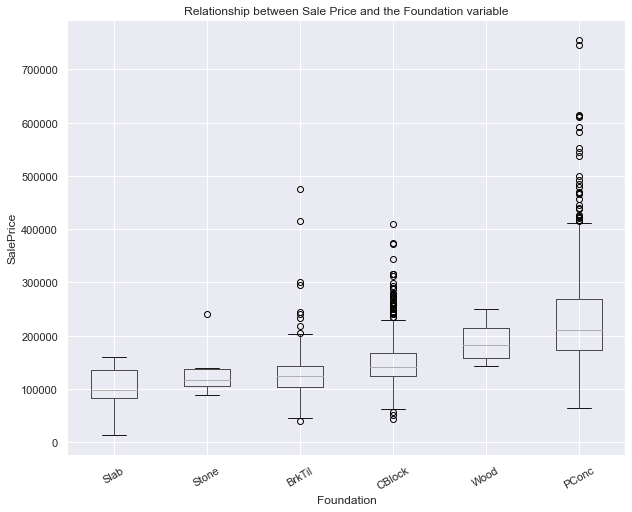

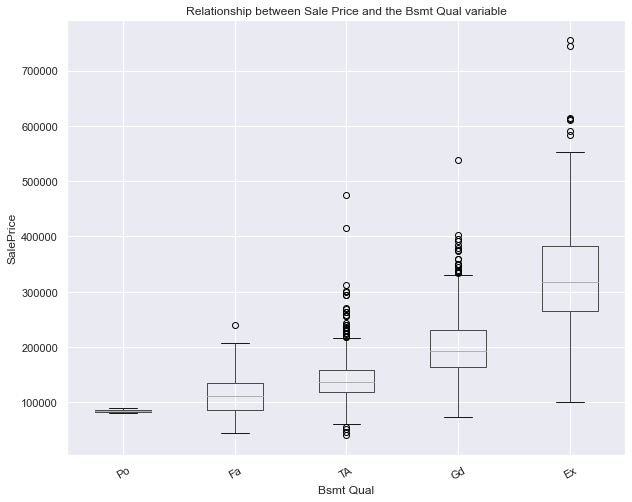

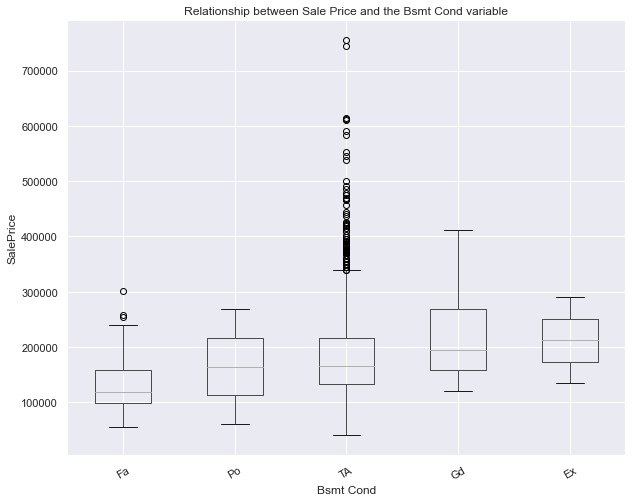

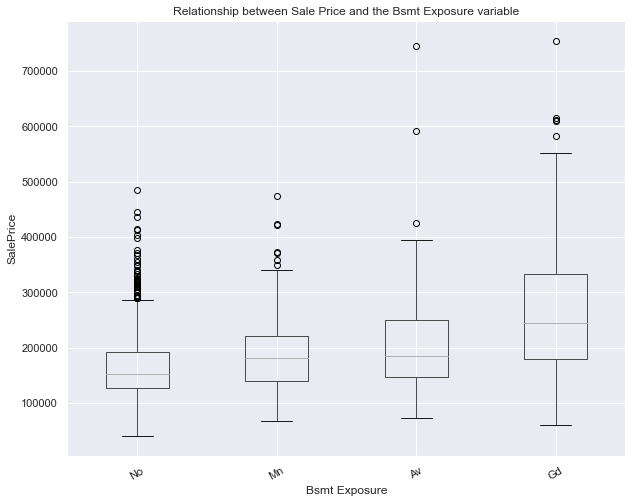

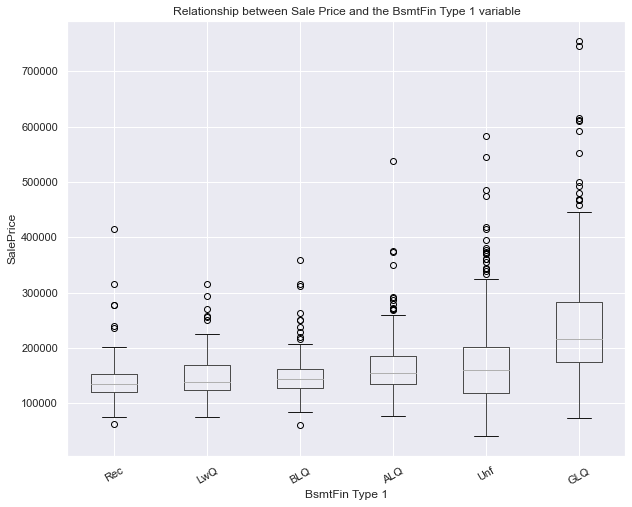

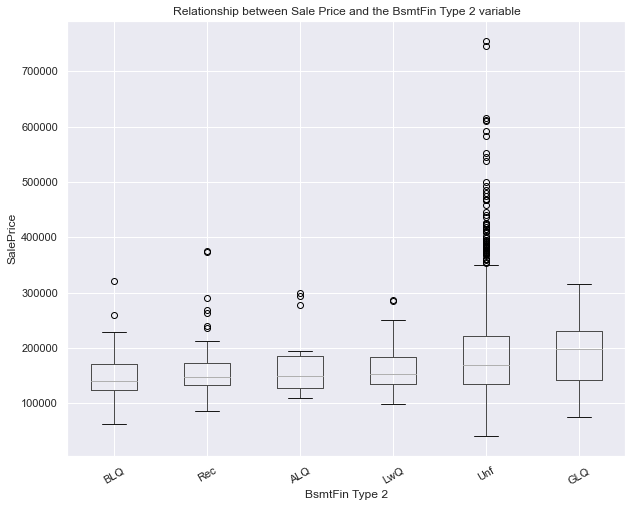

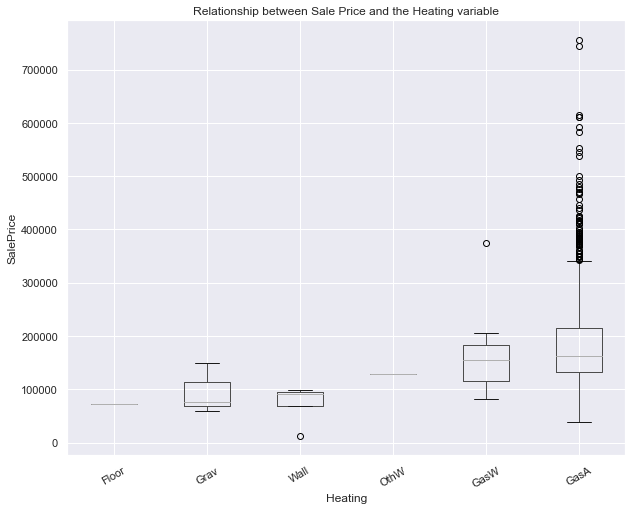

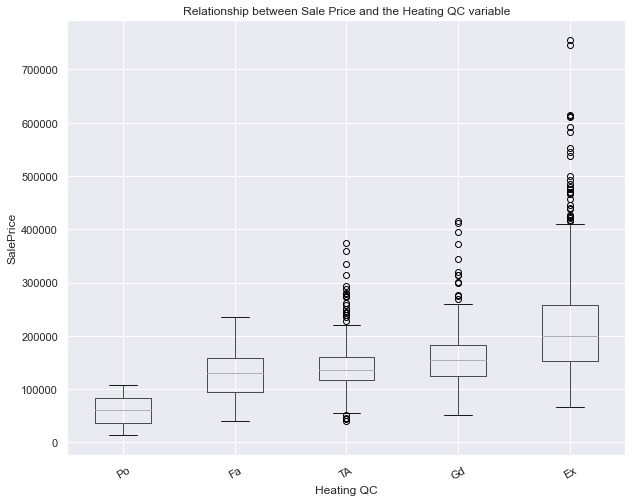

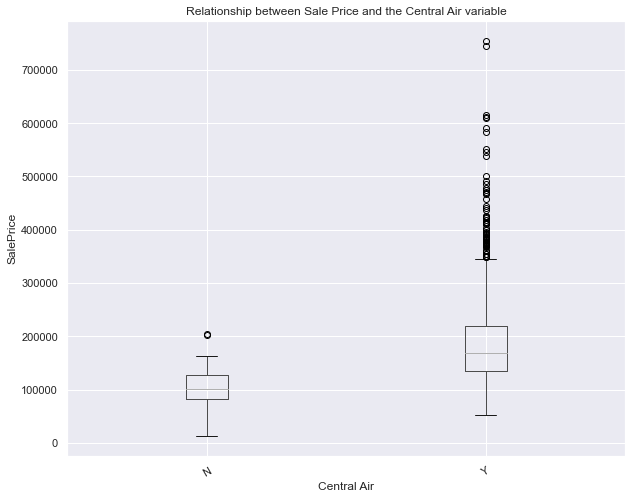

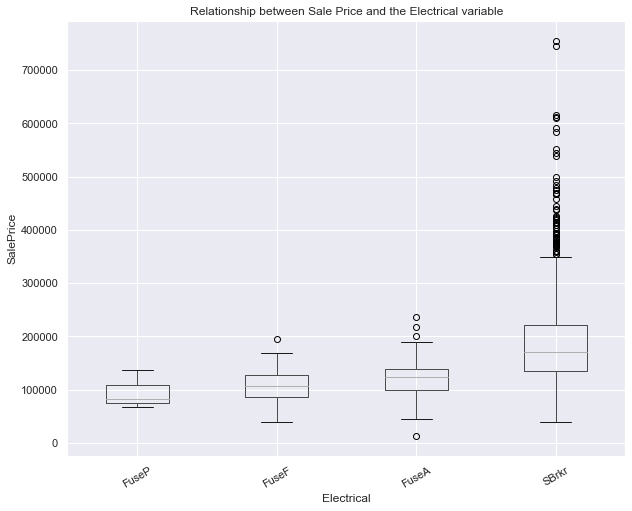

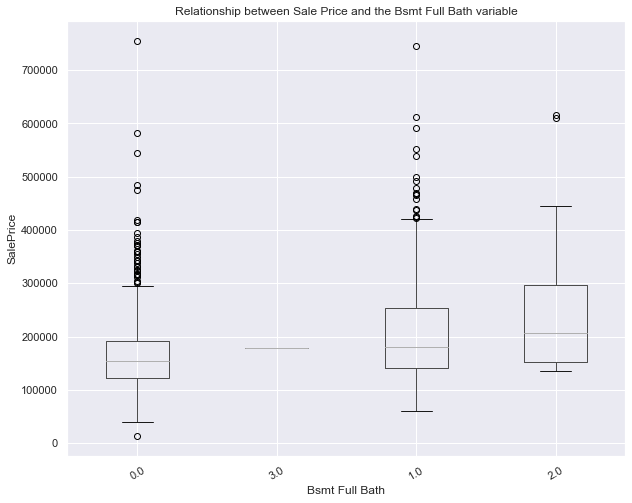

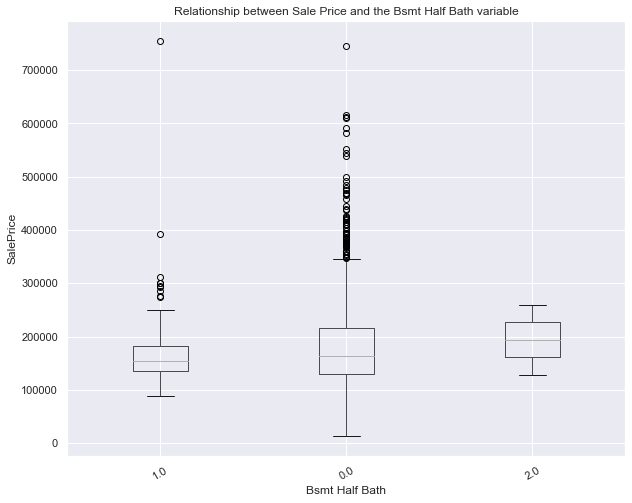

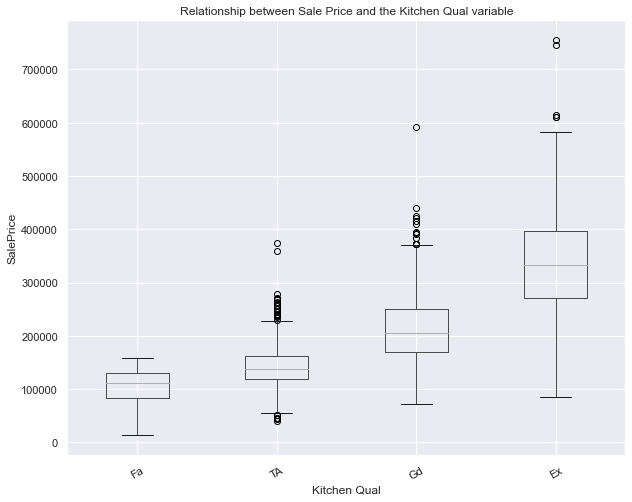

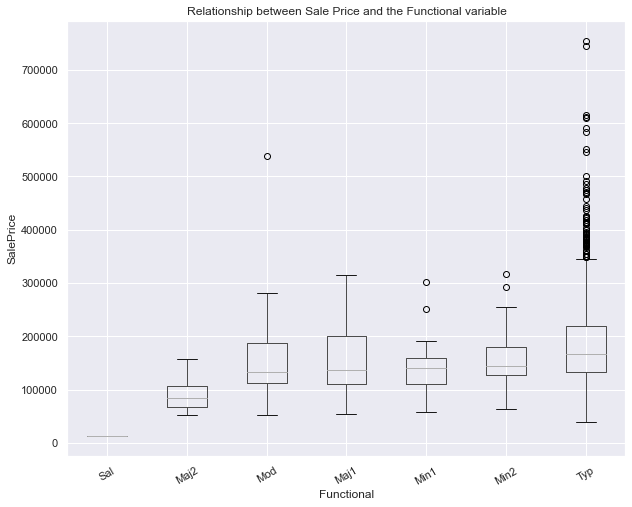

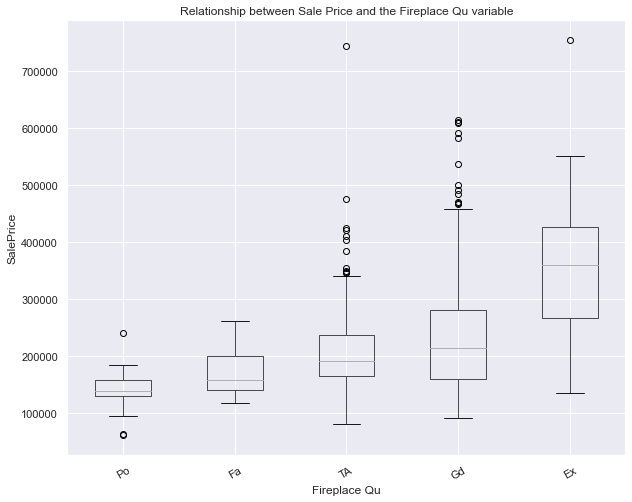

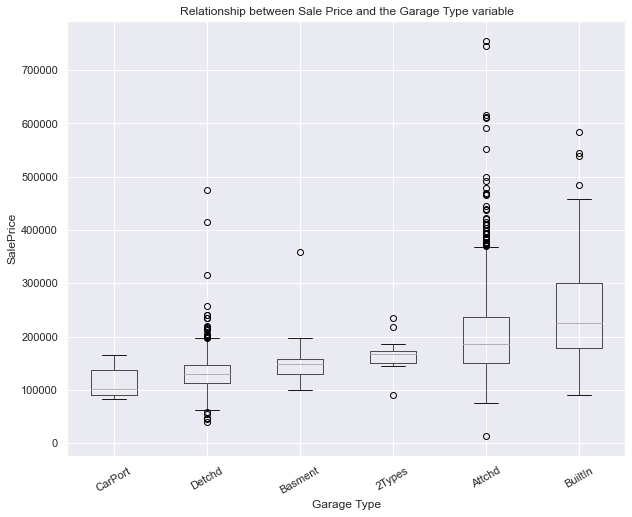

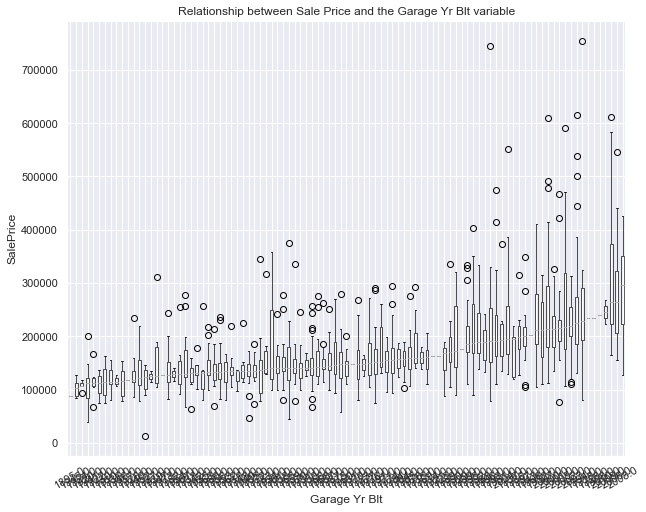

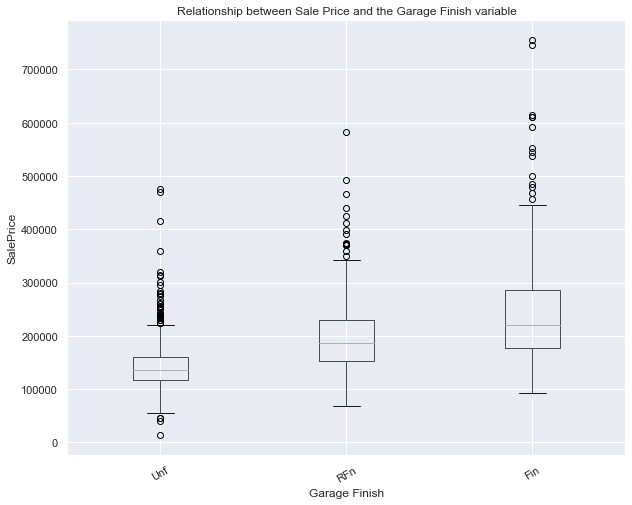

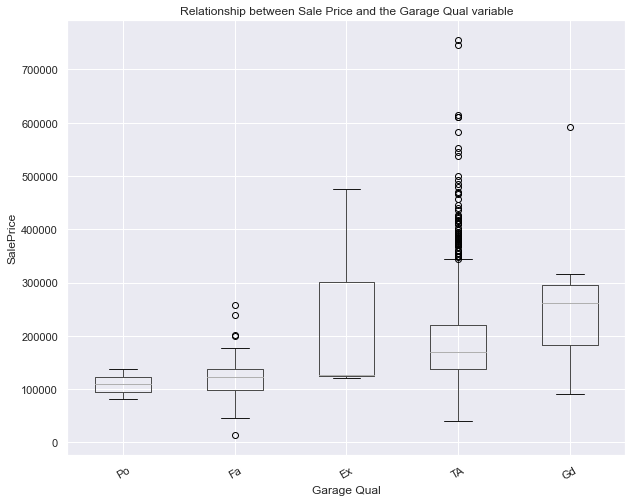

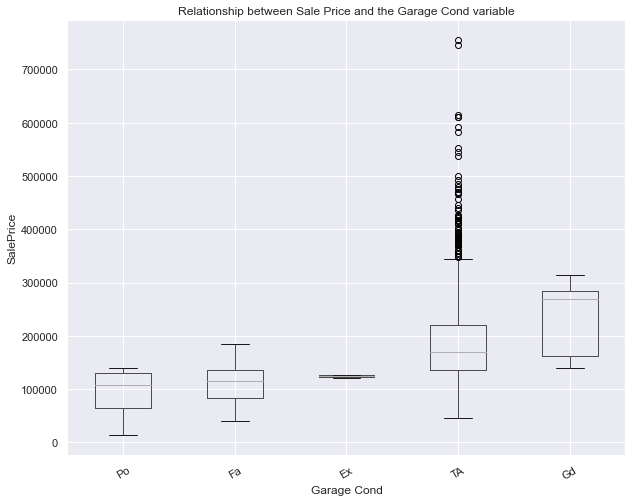

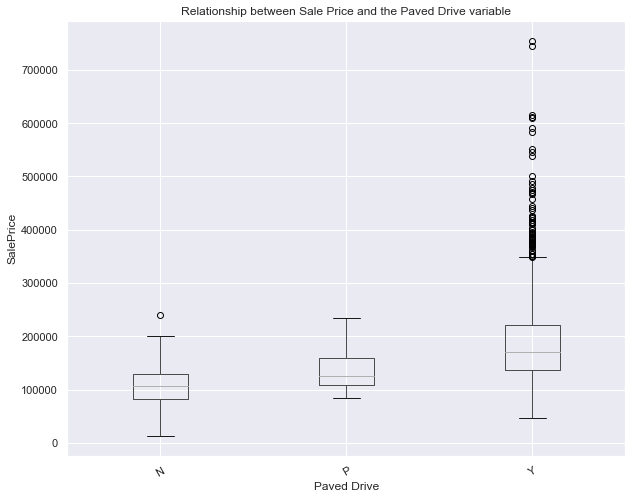

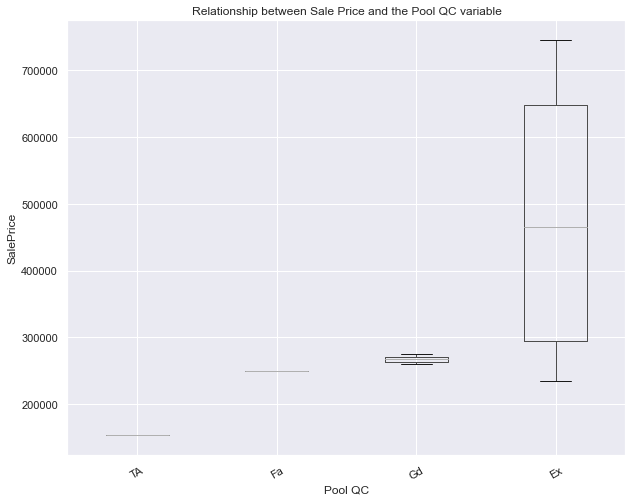

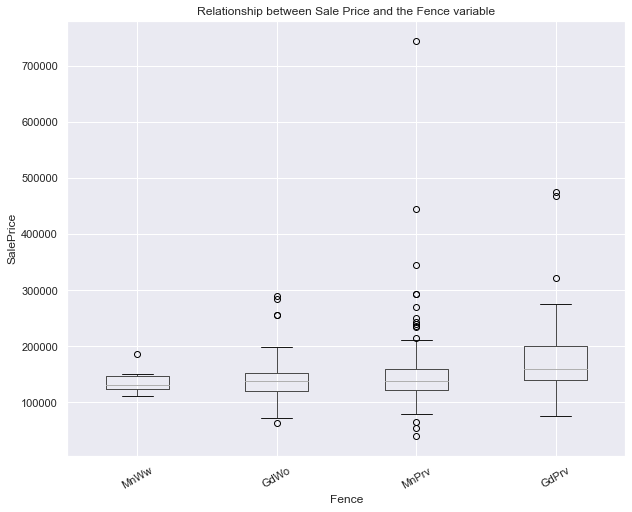

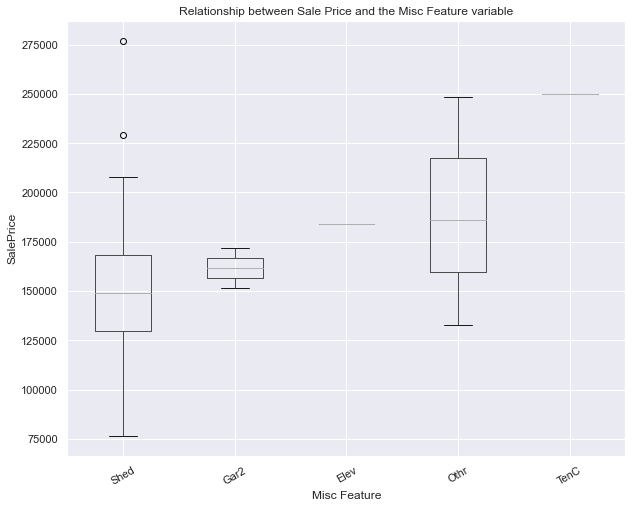

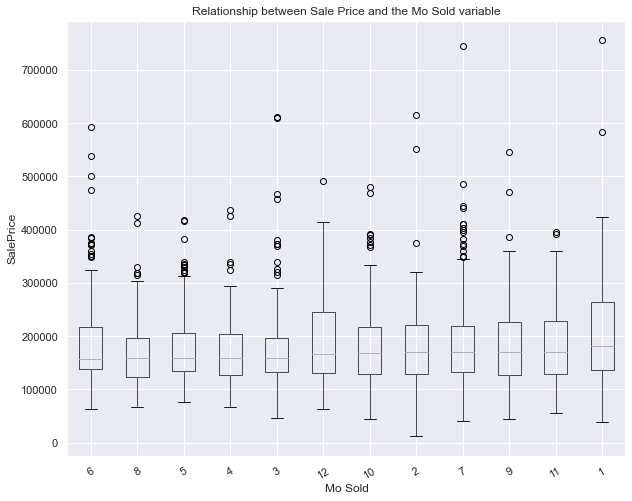

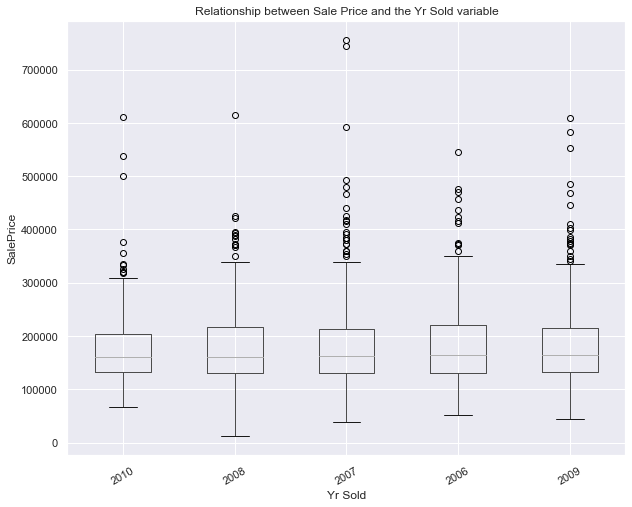

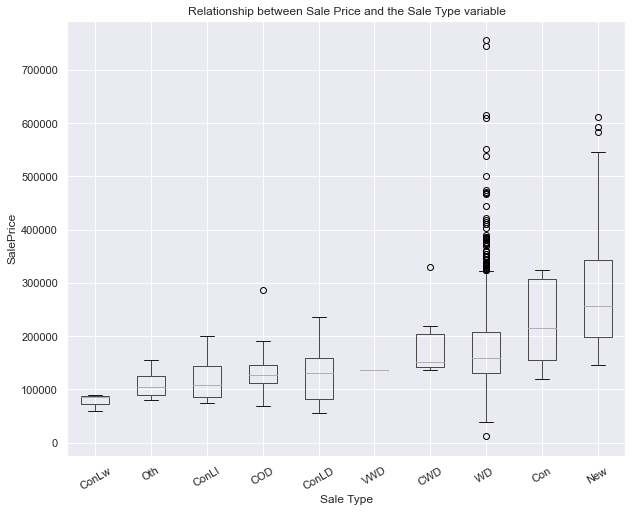

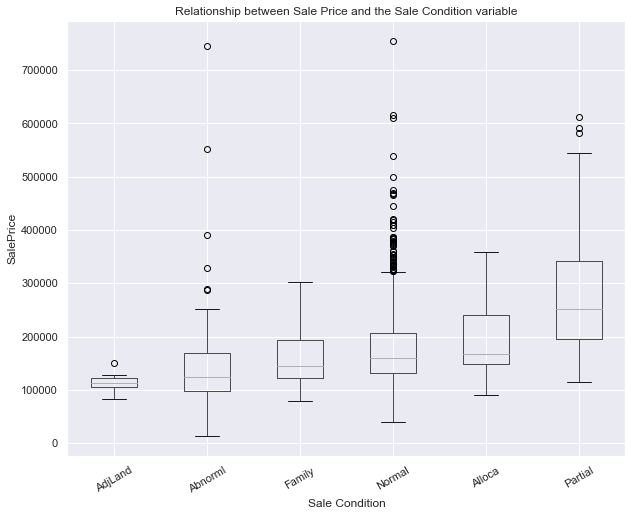

In [83]:
def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  df2[meds.index].boxplot(rot=90)

for i in cat_var:
    figure(num=None, figsize=(10, 8))
#     sns.boxplot(x = house_train[i], y = house_train['SalePrice']);
    boxplot_sorted(house_train, by = [i], column = 'SalePrice')
    plt.title(f'Relationship between Sale Price and the {i} variable');
    plt.xticks(rotation=30)
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    plt.savefig(f'Relationship between Sale Price and the {i} variable')
    plt.show()

Now we will look at the same boxplots but with outliers excluded to make comparison easier.

In [84]:
newdf = house_train.copy()

In [85]:
del newdf['Train_ID']

In [86]:
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

In [88]:
house_train_out = newdf[~((newdf[['SalePrice']] < (Q1[['SalePrice']] - 1.5 * IQR[['SalePrice']])) |(newdf[['SalePrice']] > (Q3[['SalePrice']] + 1.5 * IQR[['SalePrice']]))).any(axis=1)].copy()

In [90]:
print(f'The dataset has {house_train_out.shape[0]} observations left.')

The dataset has 1496 observations left.


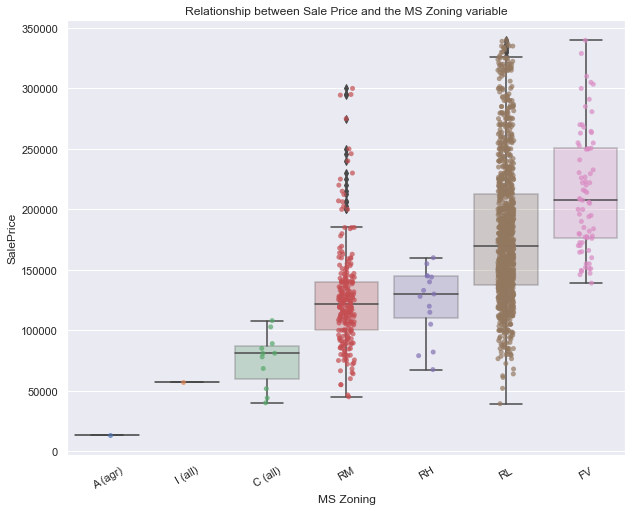

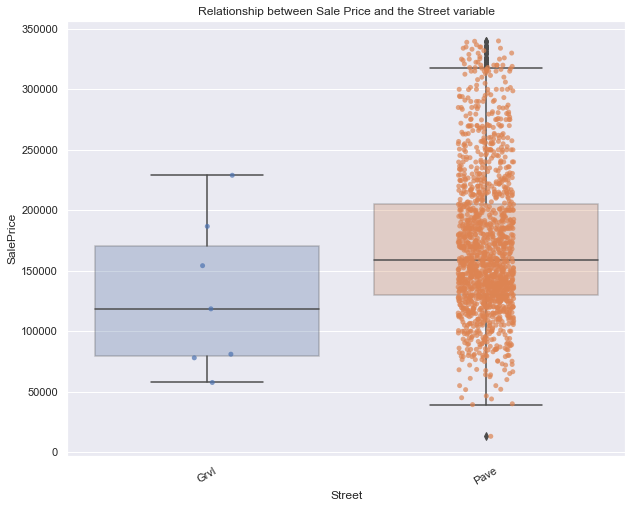

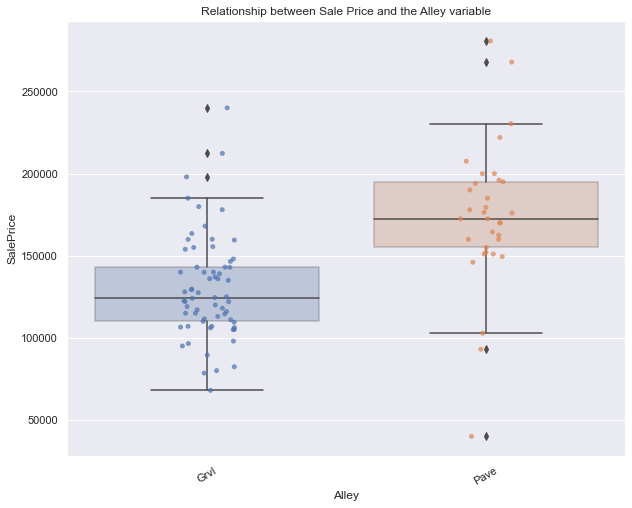

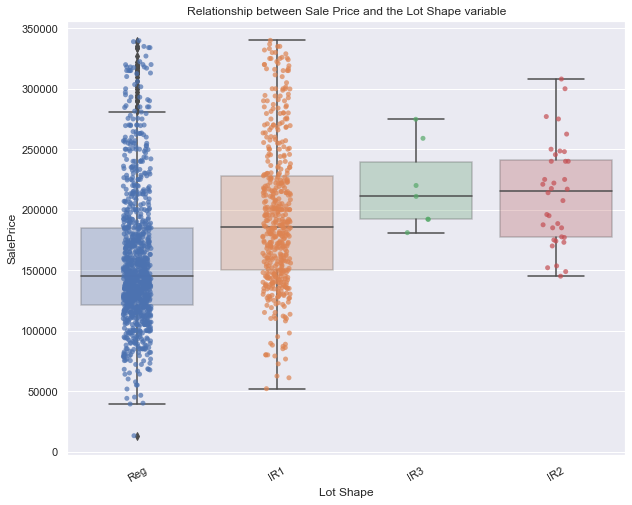

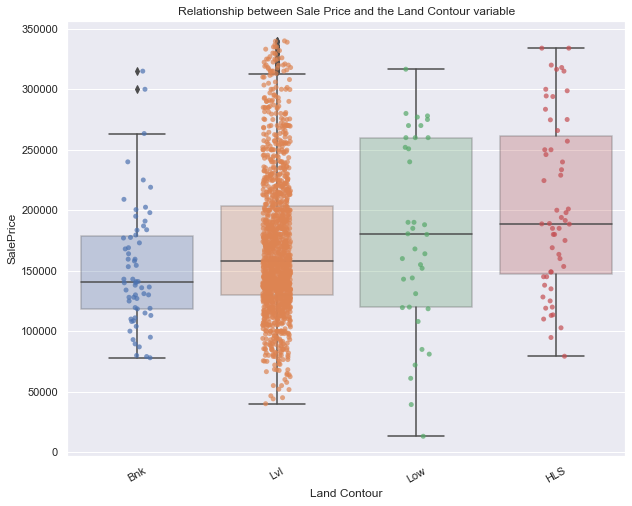

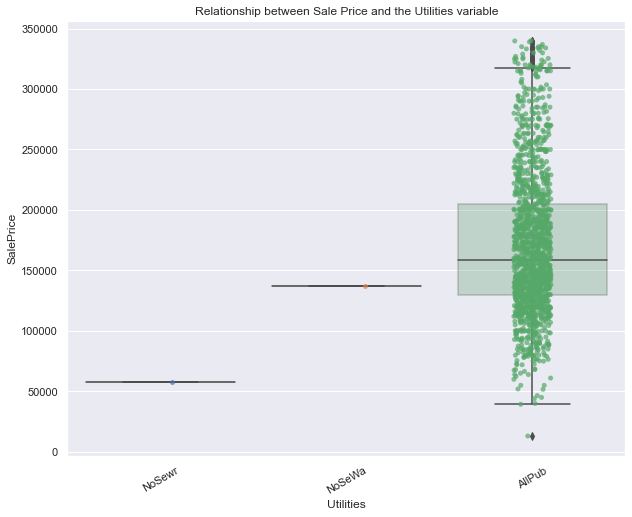

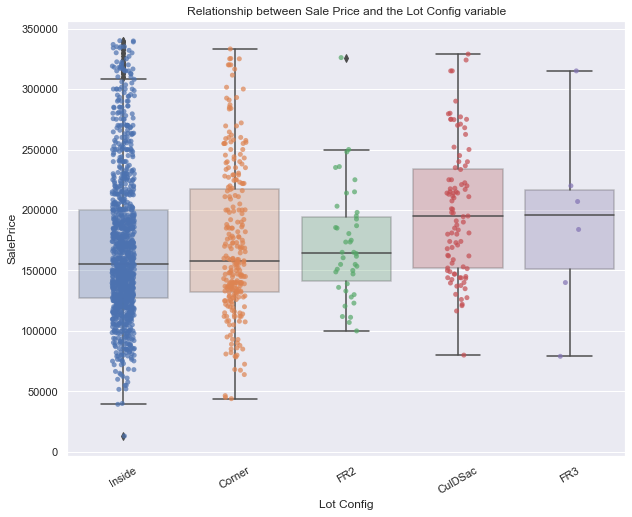

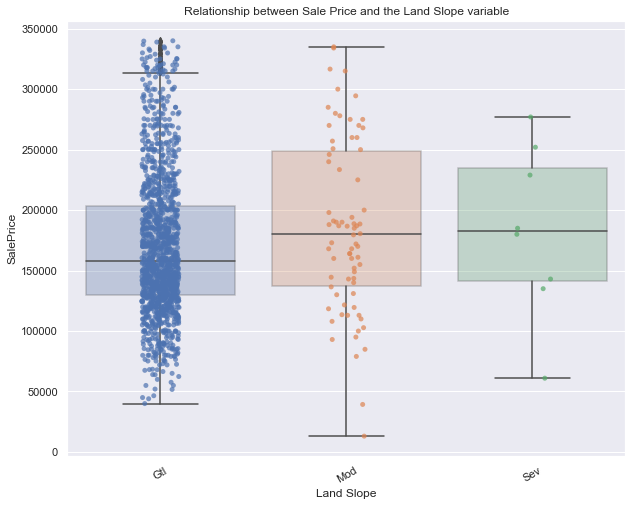

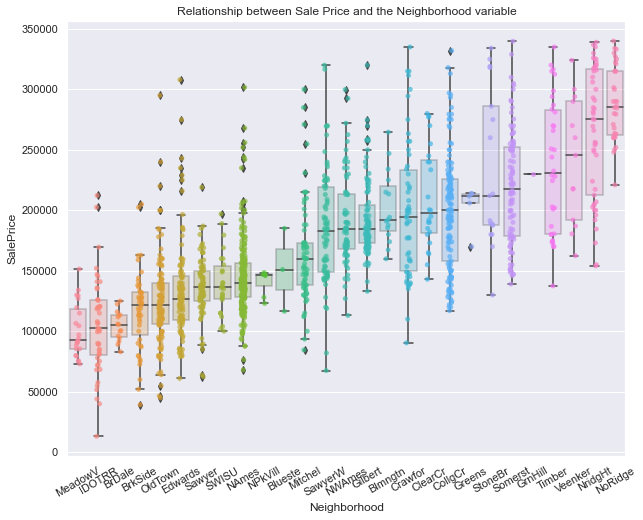

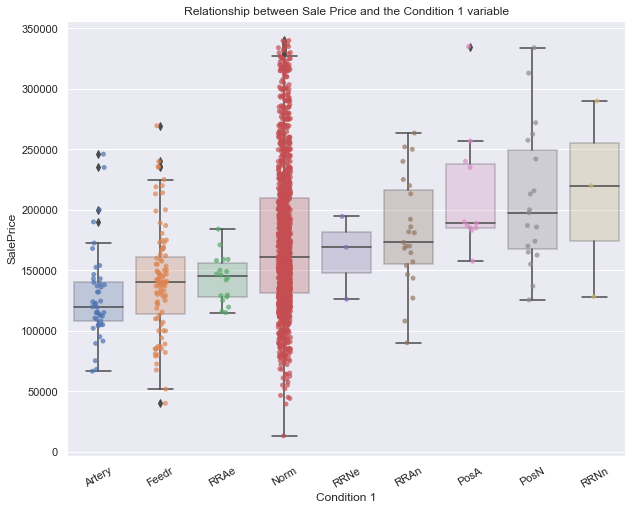

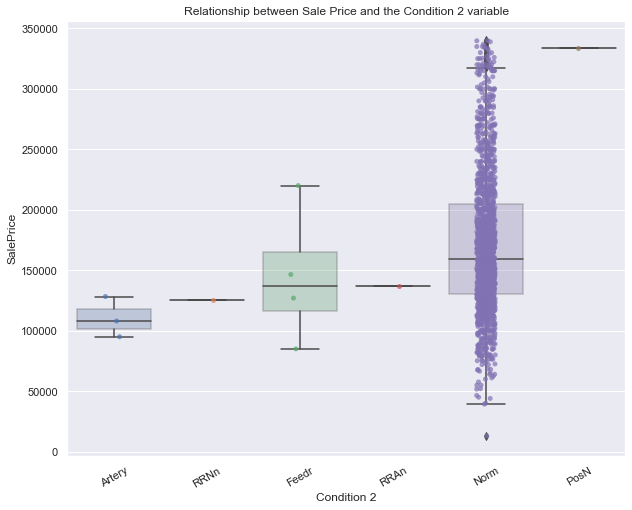

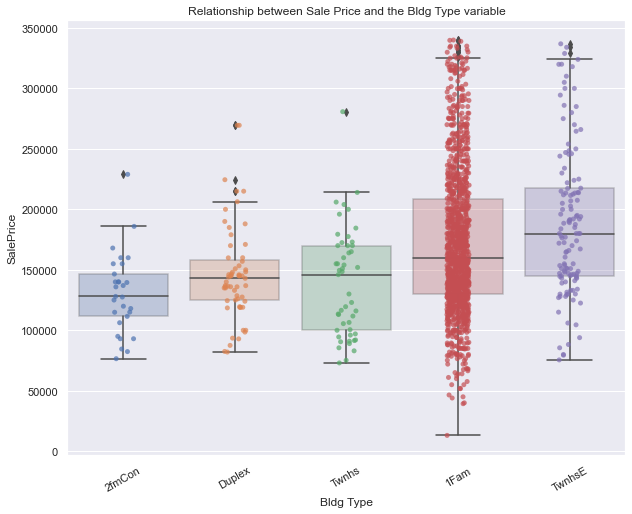

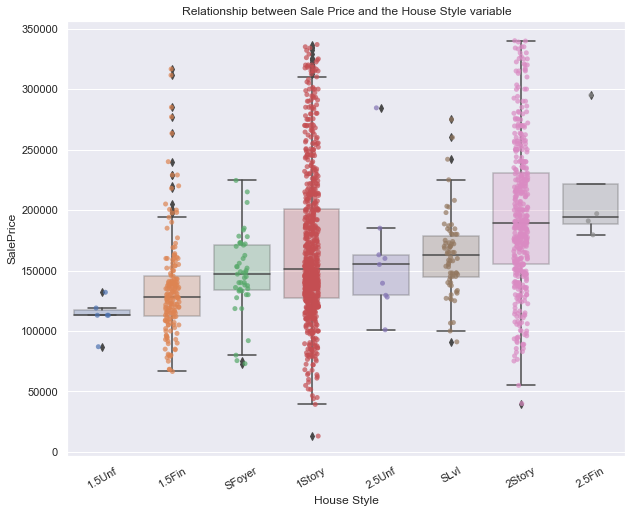

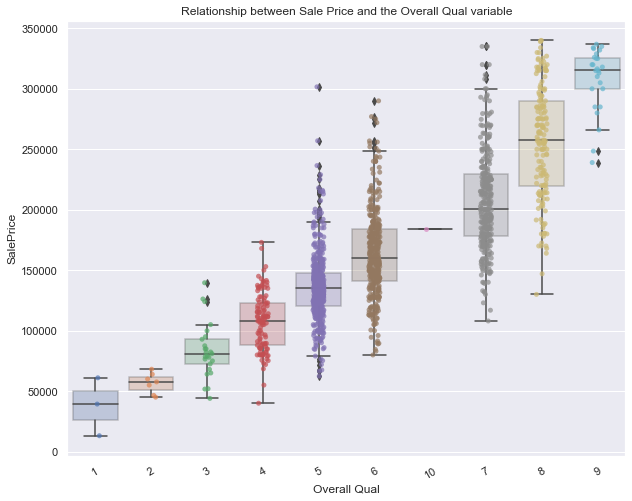

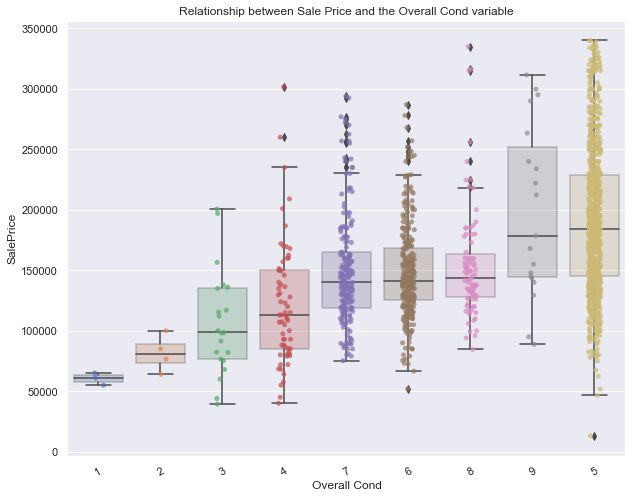

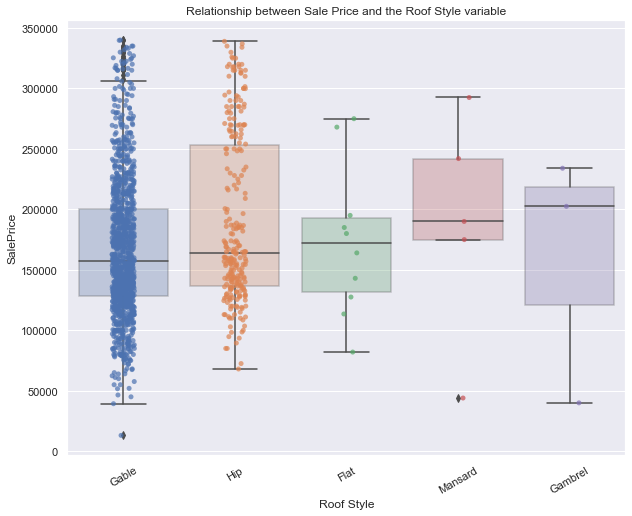

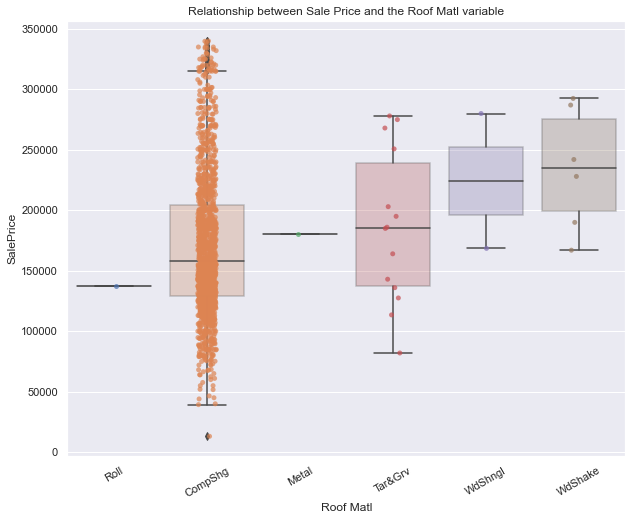

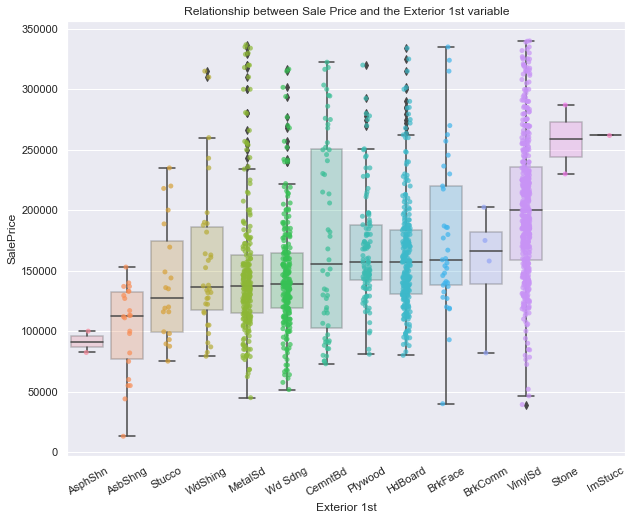

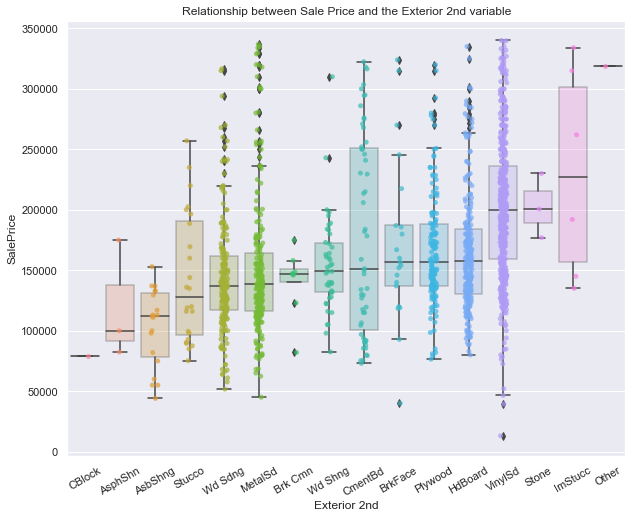

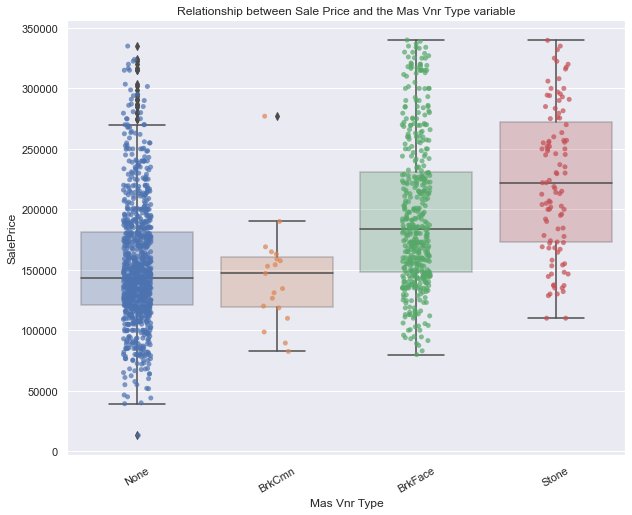

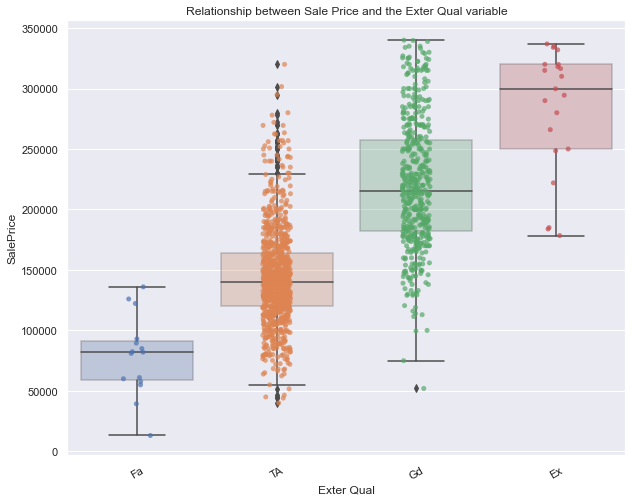

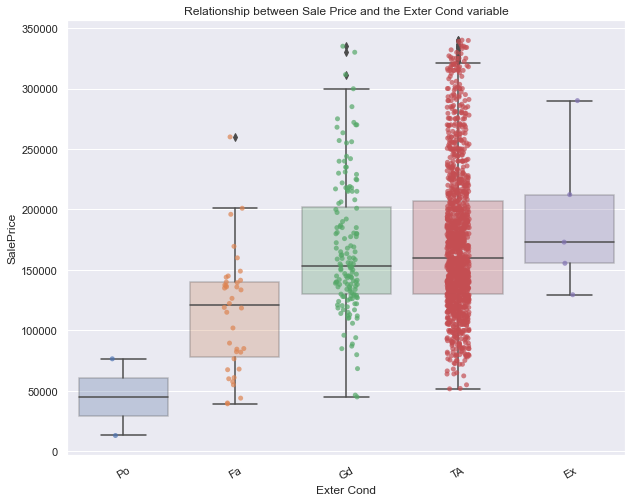

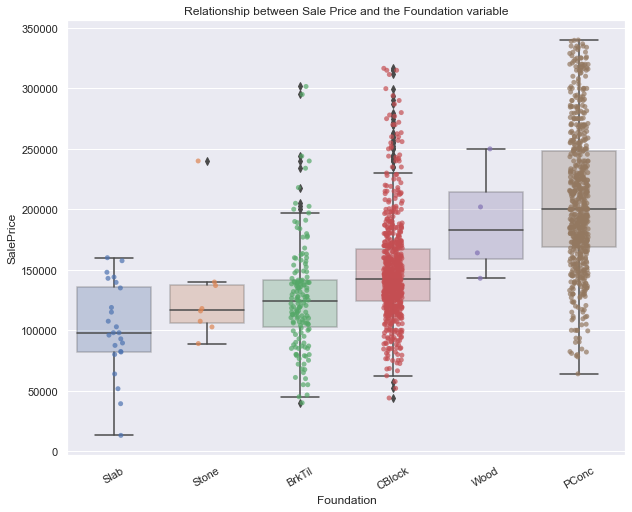

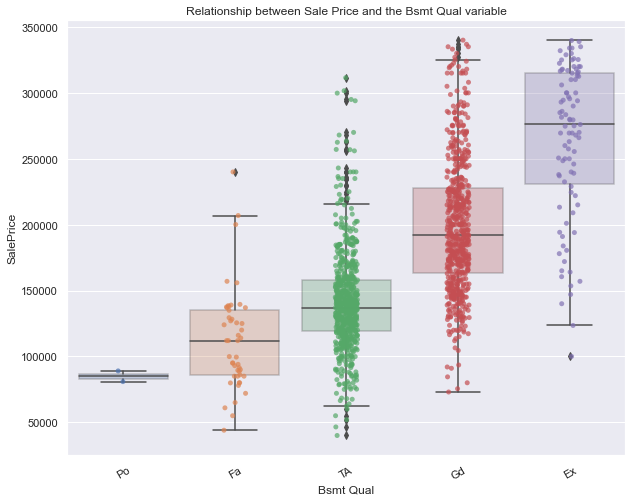

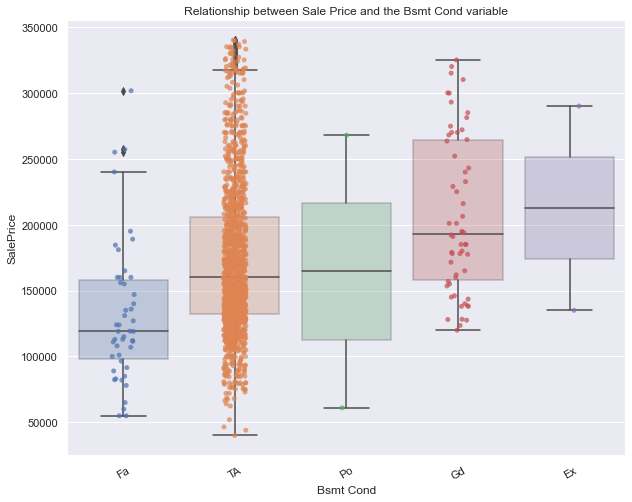

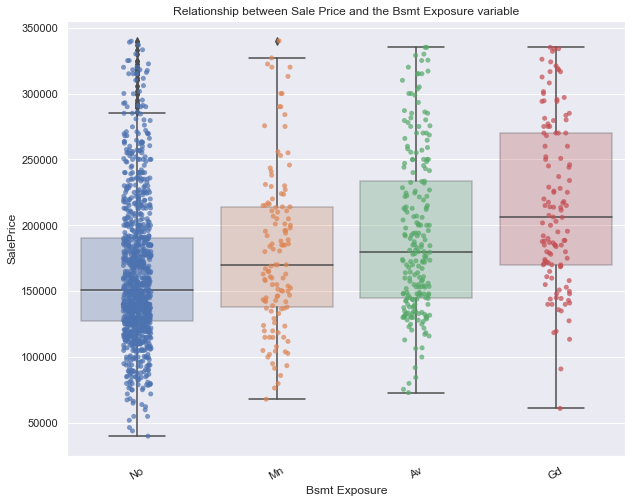

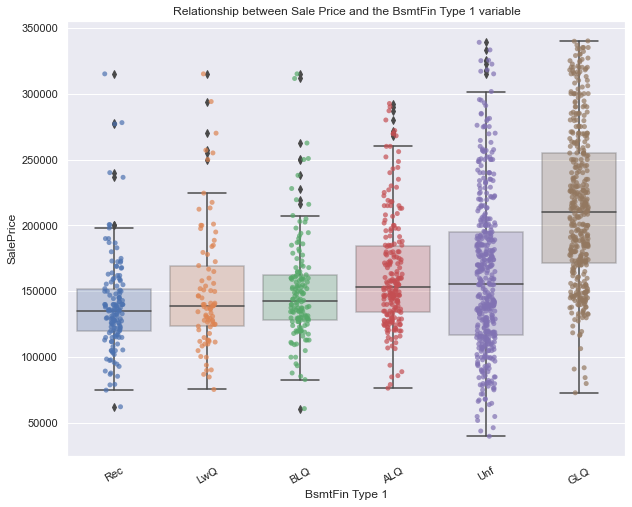

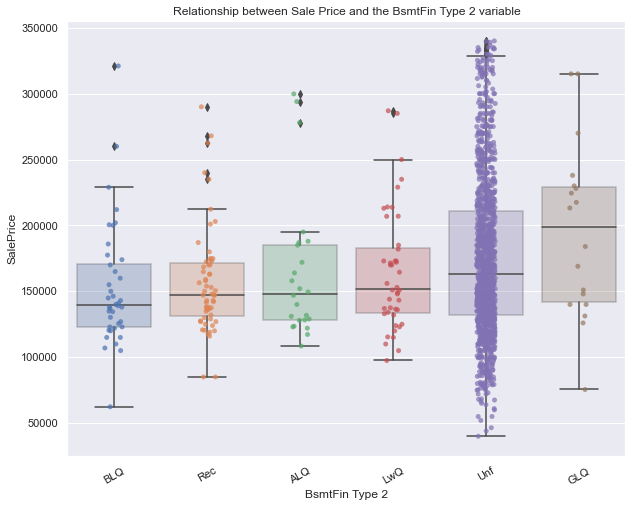

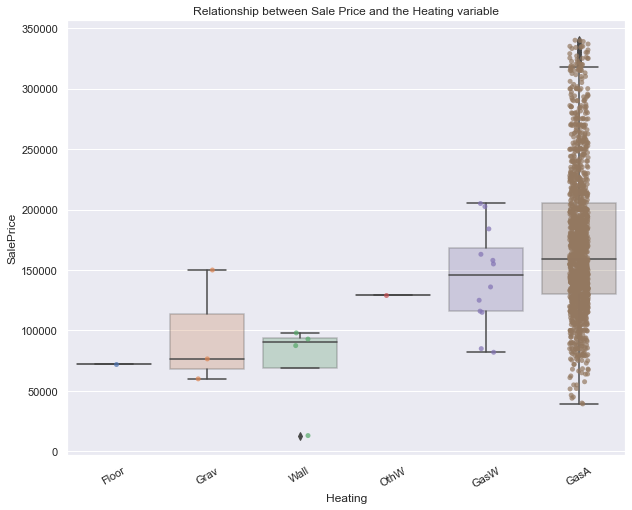

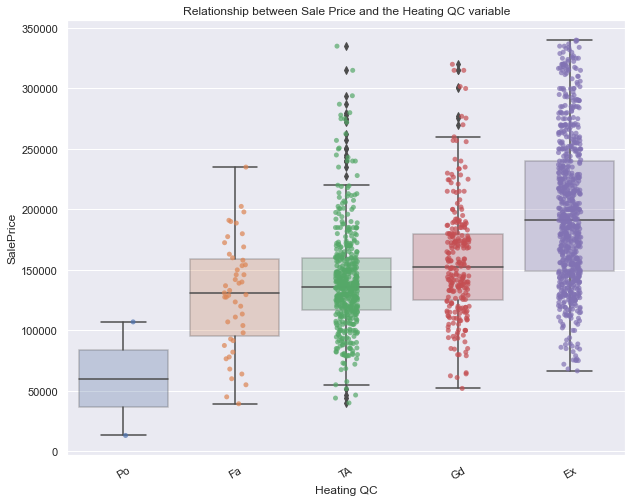

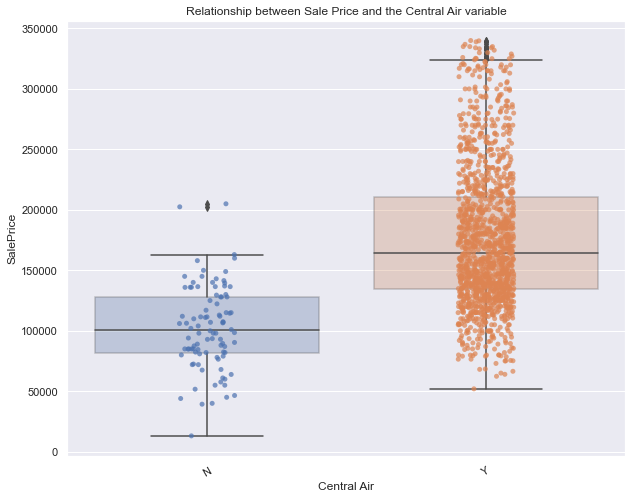

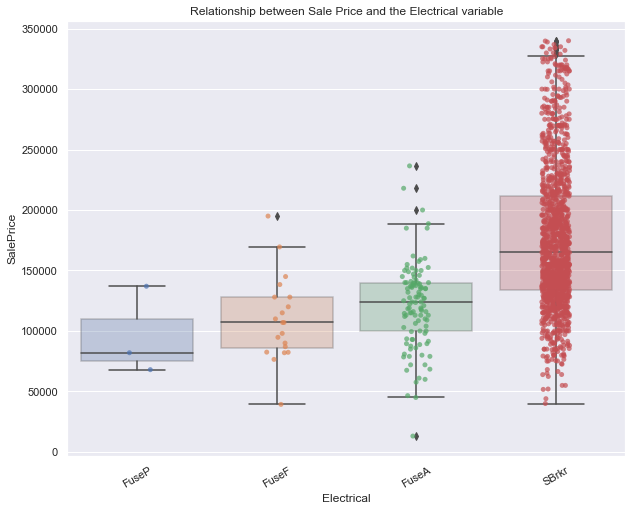

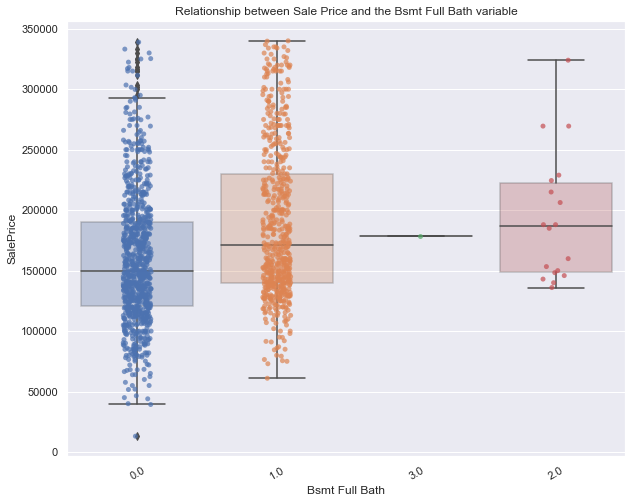

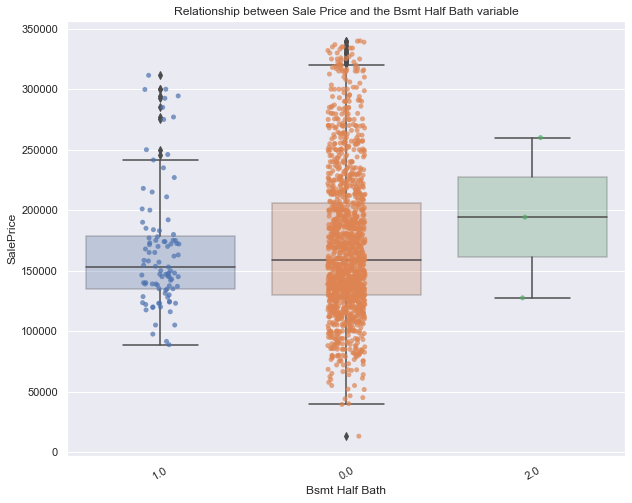

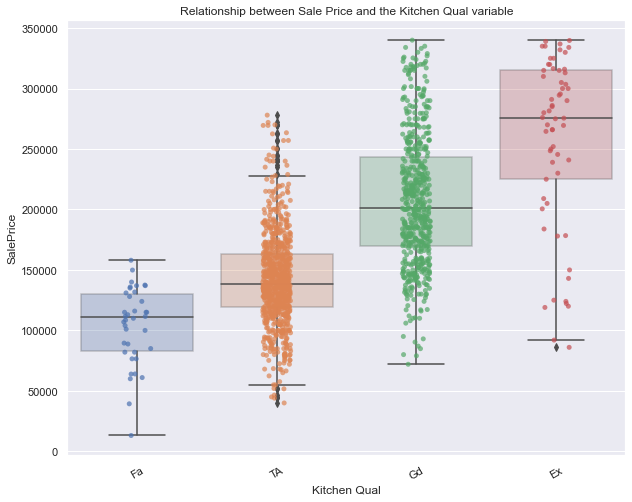

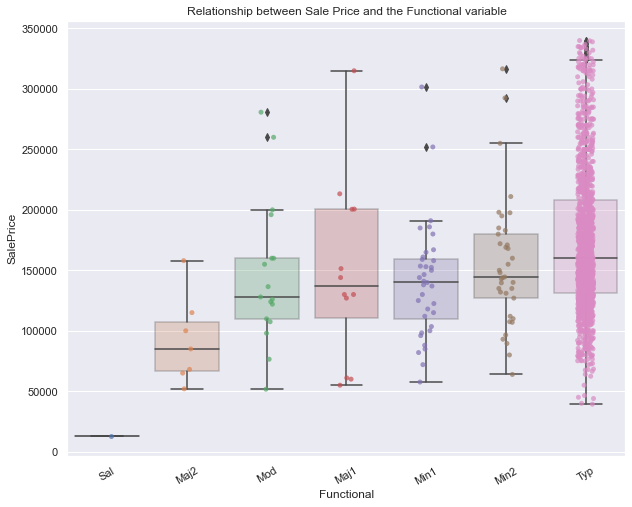

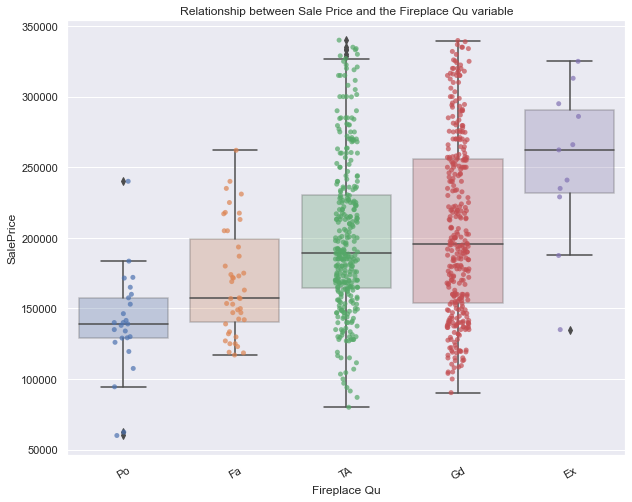

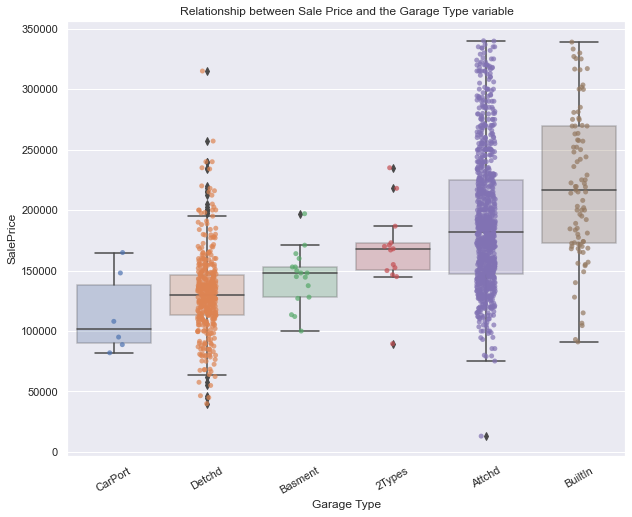

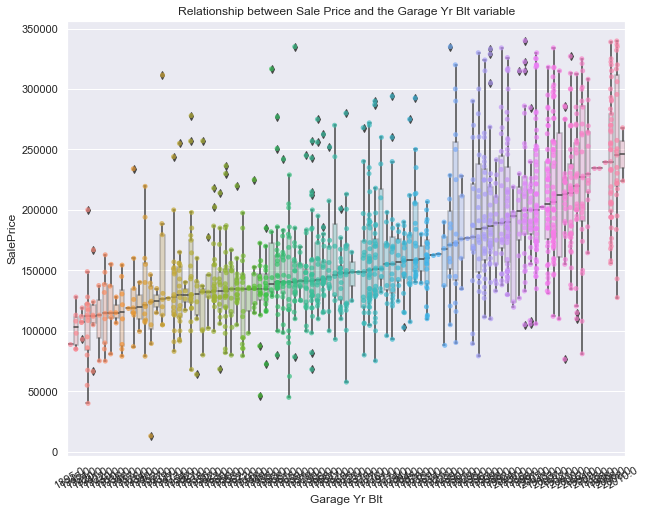

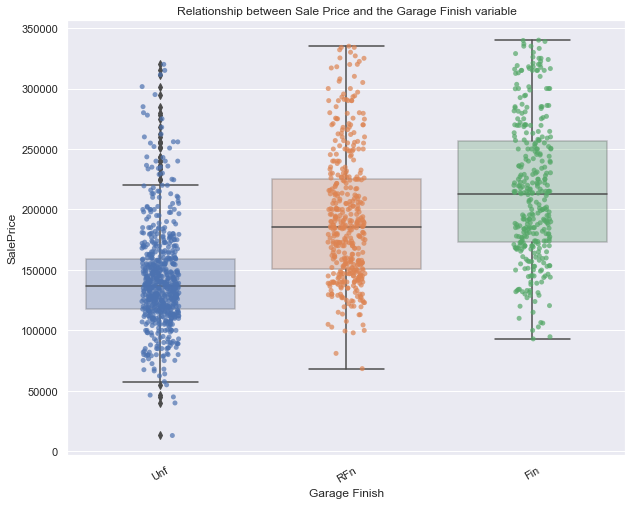

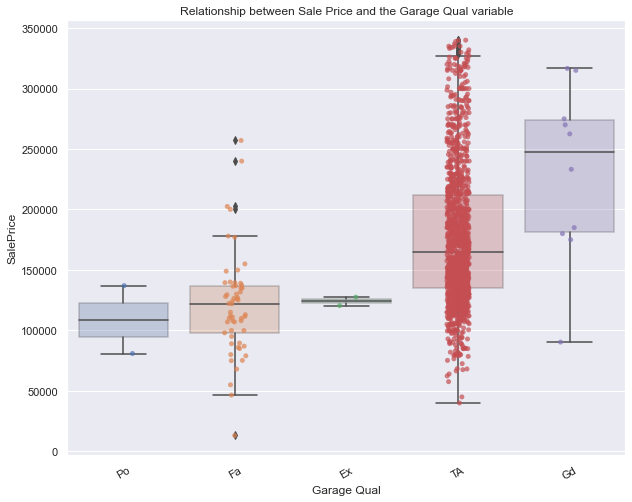

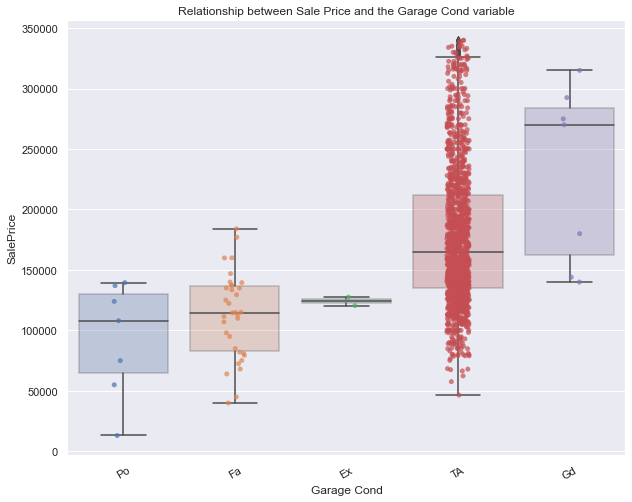

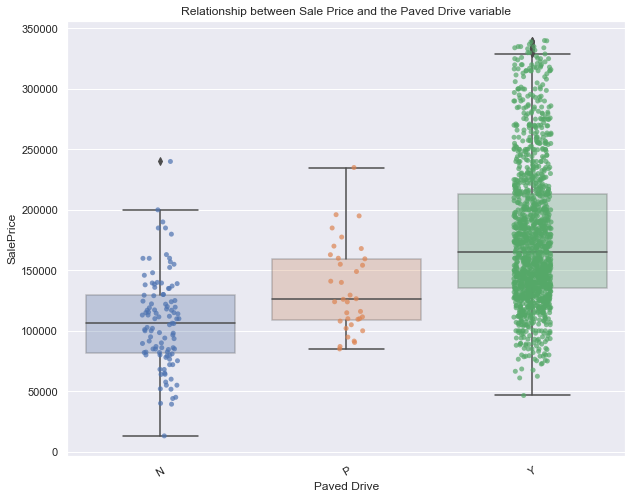

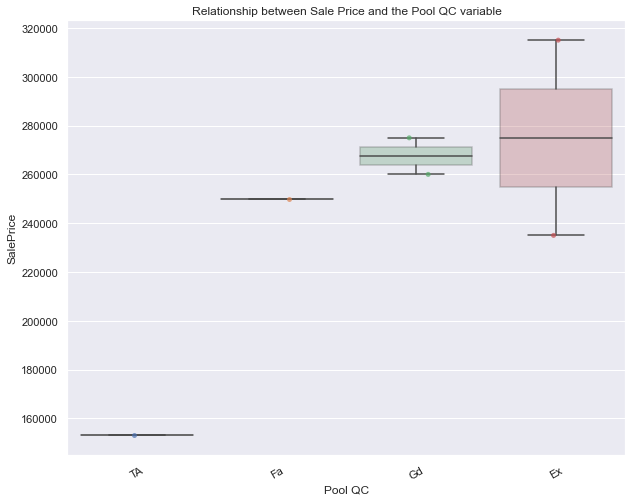

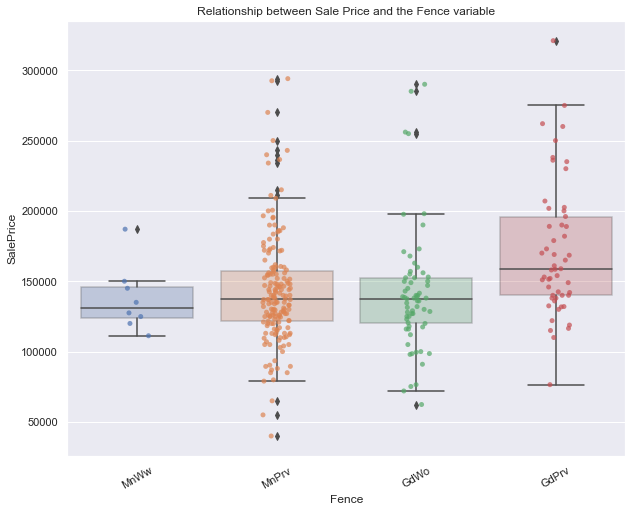

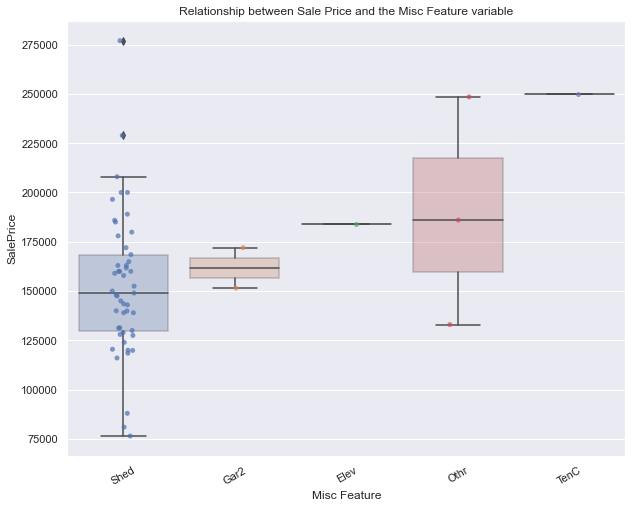

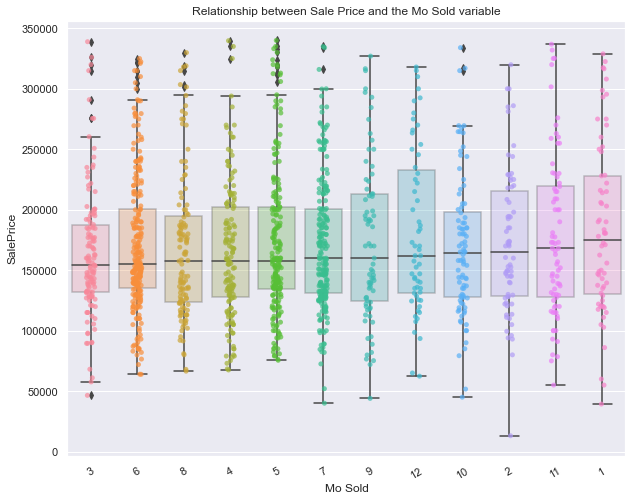

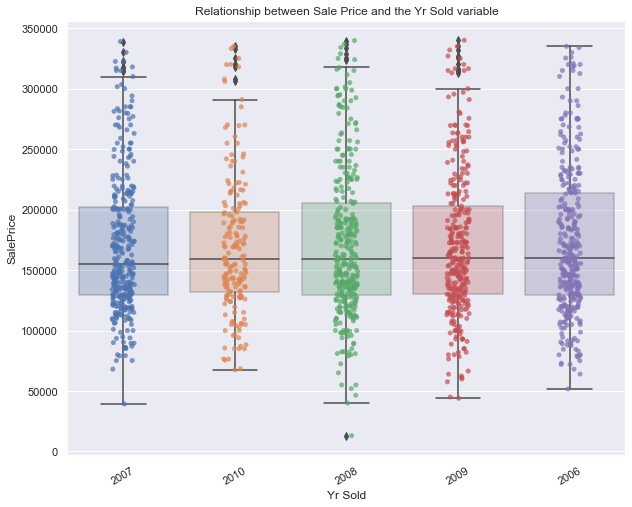

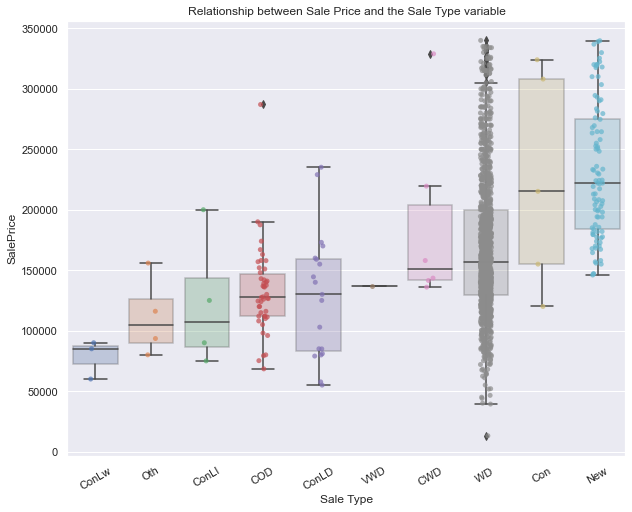

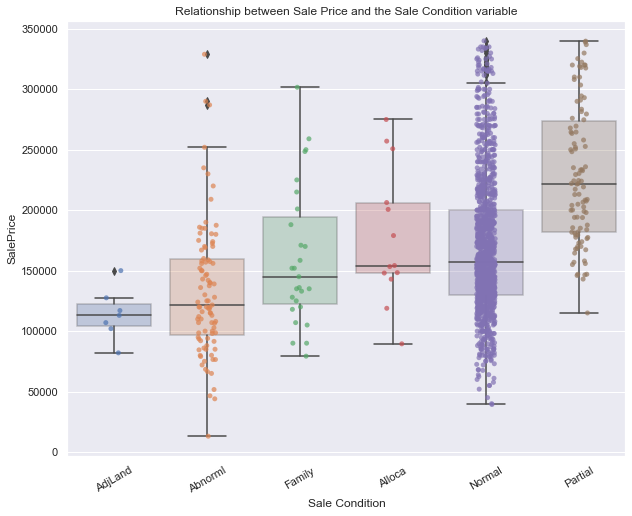

In [120]:
for i in cat_var:
    figure(num=None, figsize=(10, 8))
    x=dict(house_train_out.groupby([i])['SalePrice'].median())
    sns.boxplot(x = house_train[i], y = house_train_out['SalePrice'], boxprops=dict(alpha=.3), order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}));
#     boxplot_sorted(house_train_out, by = [i], column = 'SalePrice')
    sns.stripplot(x=i, y="SalePrice", data=house_train_out, alpha=0.7, order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}))
    plt.title(f'Relationship between Sale Price and the {i} variable');
    plt.xticks(rotation=30)
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    plt.savefig(f'Relationship between Sale Price and the {i} variable')
    plt.show()

The below indicates that with some features having NA values, this may require the use for a dummy variables. This is because NA values mostly occur not because of the data not being recorded but that the house simply does not have the characteristic. (HOW TO PROVE THIS?? -- MAY NOT BE CORRECT...IGNORE FOR NOW...)

Inspecting into the NA values that are present, there are a proportion of observations that contain missing data. Therefore, a new dataframe excluding these instances will be used in further model construction.

In [53]:
null_data = num_house_train_out[num_house_train_out.isnull().any(axis=1)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(null_data)

      MS SubClass  Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  \
23             60           NaN     11250           0.0           0.0   
26             60           NaN      9337           0.0         353.0   
39             60           NaN     13346           0.0         728.0   
41             20           NaN     14175           0.0         988.0   
43             20           NaN     13265         148.0        1218.0   
45             50           NaN     11700           0.0         606.0   
46             20           NaN     10825         174.0         747.0   
70            120          35.0      4274           NaN        1106.0   
83            120           NaN      4538         179.0        1004.0   
89             20           NaN     11120           0.0         660.0   
100            20           NaN      6718          86.0         250.0   
110            60           NaN     15038           0.0         138.0   
126            80           NaN     11333          

In [48]:
print(f'There are {num_house_train_out.isnull().any().sum()} columns in train dataset with missing values.')

There are 6 columns in train dataset with missing values.


In [61]:
num_house_train_out.dropna()

MS SubClass  Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  \
1             120          48.0      6240         176.0         863.0   
3              20          73.0      8688         228.0           0.0   
6              20          61.0      7328         140.0           0.0   
10             50          40.0      4400           0.0           0.0   
14             50          81.0      8170         270.0         526.0   
...           ...           ...       ...           ...           ...   
1548           60          64.0      7713          16.0           0.0   
1550           20          81.0     11216           0.0           0.0   
1552           20          80.0     10000         166.0         585.0   
1556           20          70.0      9926         210.0        1178.0   
1559           20          60.0      6600           0.0         816.0   

      BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  ...  \
1              0.0        461.0         1324.0        1324           0  ...   
3              0.0       1616.0         1616.0        1616           0  ...   
6              0.0       1450.0         1450.0        1450           0  ...   
10             0.0        648.0          648.0         734         384  ...   
14             0.0        496.0         1022.0        1122         549  ...   
...            ...          ...            ...         ...         ...  ...   
1548           0.0        728.0          728.0         728         728  ...   
1550           0.0       1489.0         1489.0        1489           0  ...   
1552           0.0        856.0         1441.0        1392           0  ...   
1556           0.0        436.0         1614.0        1614           0  ...   
1559           0.0          0.0          816.0         816           0  ...   

      Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
1              192             38               0           0             0   
3              208             59               0           0             0   
6                0             93               0           0             0   
10               0              0               0           0             0   
14               0              0               0           0             0   
...            ...            ...             ...         ...           ...   
1548           100             24               0           0             0   
1550             0            140               0           0             0   
1552           168             49               0           0             0   
1556           100             38               0           0             0   
1559             0              0               0           0             0   

      Pool Area  Misc Val  Age  Last remod/add  SalePrice  
1             0         0    3               3     254000  
3             0         0    1               1     232000  
6             0         0    1               0     224243  
10            0         0   86              56     116000  
14            0         0   77              56     218000  
...         ...       ...  ...             ...        ...  
1548          0         0    0               0     177594  
1550          0         0    0               0     232600  
1552          0         0    5               5     215000  
1556          0         0    2               1     245700  
1559          0         0   26               5     138000  

[538 rows x 30 columns]

In [ ]:
# Fix above error and give a text print out of variable values 
#regarding distributions where the number is way too small to visualise...